# ML for climate and Energy (MEC51057)
# Group project: Weather station 2024-2025

<div class="alert alert-block alert-info">

**Mentor**:
- Julio Cardenas

**Students**:
- Dimitri Iratchet
- Fabien Lagnieu
- Tristan Waddington
</div> 


Go to [quickstart](#253-final-dataset-reduced-and-normalized-measurments).

In [66]:
# imports
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch.nn as nn
import torch.optim as optim

from pathlib import Path
from importlib import reload

from sklearn.linear_model import LinearRegression
from torch.utils.data import DataLoader

# Project imports
from src import load_data, display, DL_models

In [2]:
# Constants
# Retrain Deep Learning models, if False, load the models from disk
RETRAIN_MODELS: bool = False
SAVE_MODELS_PATH: Path = Path("saved_models")

--- 
## 1. Project presentation

### 1.1 General presentation

<div class="alert alert-block alert-info">

**Aim**: <br>
Paris weather station was cyber-hacked, and is therefore unable to share
its weather measures since the beginiing of 2019. **Our task is to predict this missing data from
other European weather stations measures**.

Furthermore, we suspect that since 2016 some reports have been modified by these 
hackers in a previous altering attack. We have to spot these modifications.

**Dataset**: <br>
We have access to the full history of measurements of 5 stations, including
Paris, reporting 10 weather variables that will be described bellow. 
The measures were reported hourly and span form year 1980 to 2019 (included, exact common timeframe: 1980-01-01 07:00:00 to 2019-12-31 23:00:00).

For educative purpose, we decided to split them on 3 different datasets:
- Confirmed clean timeframe (train): year 1980-2015
- Suspicious time-frame (test): year 2016-2018
- "Real time" stream (validation): year 2019

</div> 

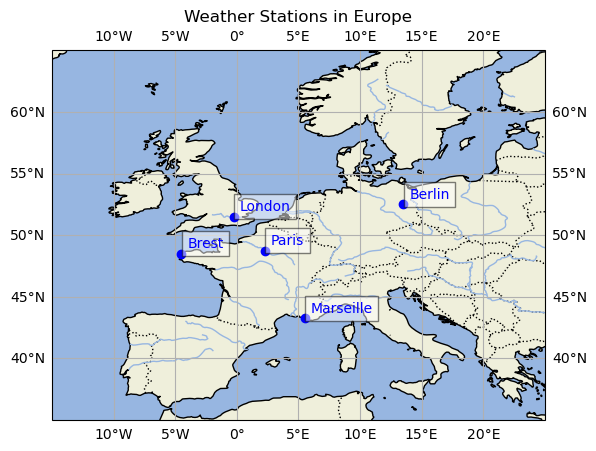

In [3]:
# Display the weather stations on a map, as illustration
display.display_weather_stations()

### 1.2 Data files presentation

<div class="alert alert-block alert-info">

**Raw format**: <br>
We are given the raw measurements of 5 weather stations in separate files, split by station and by feature. Each `.nc` file can be loaded with the `xarray` module in a specific format. 
</div> 

In [4]:
# Display the contents of the folder weater_data
data_folder = Path("data", "weather_data")
print("Contents of weather_data folder:")
for file in data_folder.iterdir():
    if file.is_dir():
        print(f"- {file.name}/")
        print(f"\t{"; ".join(sub_file.name for sub_file in file.iterdir())}")

Contents of weather_data folder:
- paris/
	blh.nc; t2m.nc; tcc.nc; u10.nc; skt.nc; d2m.nc; v10.nc; tp.nc; ssrd.nc; sp.nc
- marseille/
	blh.nc; t2m.nc; tcc.nc; u10.nc; skt.nc; d2m.nc; v10.nc; tp.nc; ssrd.nc; sp.nc
- brest/
	blh.nc; t2m.nc; tcc.nc; u10.nc; skt.nc; d2m.nc; v10.nc; tp.nc; ssrd.nc; sp.nc
- london/
	blh.nc; t2m.nc; tcc.nc; u10.nc; skt.nc; d2m.nc; v10.nc; tp.nc; ssrd.nc; sp.nc
- berlin/
	blh.nc; t2m.nc; tcc.nc; u10.nc; skt.nc; d2m.nc; v10.nc; tp.nc; ssrd.nc; sp.nc


In [5]:
# display the explanation of the variables
print(
    "\n".join(":\t".join([var, legend]) for var, legend in display.var_legend.items())
)

t2m:	Air temperature at 2 m above the ground [K]
d2m:	Dew point at 2 m above the ground [K]
u10:	Zonal wind component at 10 m [m/s]
v10:	Meridional wind component at 10 m [m/s]
skt:	Skin temperature [K]
tcc:	Total cloud cover [0-1]
sp:	Surface pressure [Pa]
tp:	Total precipitation [m]
ssrd:	Surface solar radiation (downwards) [J/m^2]
blh:	Boundary layer height [m]


---
## 2. Data Loading / preparation / study

<div class="alert alert-block alert-info">

To facilitate the following study, **this files are merged onto `Pandas` `Dataframe`**.

**Treatment**: <br>
Given the physicial differences in the meaning and scale of each feature, we decided to
**normalize** the dataset **by feature** to use them in a machine learning process. But to be able to interpret back the results of our models, the inverse transformation should be available. That's why we specifically return the scalers during the loading process.

**Signification**: <br>
Each of the 10 features represent a physical measurement that is studied in the next part.
</div>

### 2.1 Load the xarrays and transform into Pandas DataFrame

In [6]:
# Origin of the files
base_path: Path = Path("data", "weather_data")
# Load into a dictionary of all features by city
weather_stations_data: dict[str, pd.DataFrame] = load_data.load_nc_files_by_subfolders(
    base_path
)
# Get the names of the cities
cities: list[str] = list(weather_stations_data.keys())

# Display the description of Paris data
print("Description of Paris data:")
weather_stations_data["paris"].describe()


Description of Paris data:


blh            d2m            skt             sp  \
count  359424.000000  359424.000000  359424.000000  359424.000000   
mean      604.306396     280.462677     284.343475  100415.398438   
std       470.654724       5.681719       7.730994     906.625916   
min         9.829140     254.678604     252.089996   94526.585938   
25%       205.043015     276.560242     278.848358   99890.281250   
50%       492.636017     280.908752     283.880219  100472.187500   
75%       915.939209     284.717285     289.336365  101001.007812   
max      3572.631348     295.901764     317.110504  103395.062500   

               ssrd            t2m            tcc             tp  \
count  3.594240e+05  359424.000000  359424.000000  359424.000000   
mean   4.776326e+05     284.404175       0.664978       0.000082   
std    7.350270e+05       7.121849       0.369240       0.000297   
min   -1.901566e+00     256.771332       0.000000       0.000000   
25%    0.000000e+00     279.366882       0.347229       0.000000   
50%    2.099200e+04     284.210266       0.842072       0.000000   
75%    7.504640e+05     289.264038       0.998413       0.000009   
max    3.315712e+06     314.154785       1.000000       0.011550   

                 u10            v10  
count  359424.000000  359424.000000  
mean        0.864824       0.351672  
std         2.641523       2.879269  
min        -9.424118     -10.220169  
25%        -1.184677      -1.833076  
50%         0.842087       0.232651  
75%         2.671062       2.403114  
max        16.235458      14.881912

This confirms that the scale of each data is different. We will need to **normalize** the data before training a model.

### 2.2 Data exploration
Before transforming the data, let's study it.

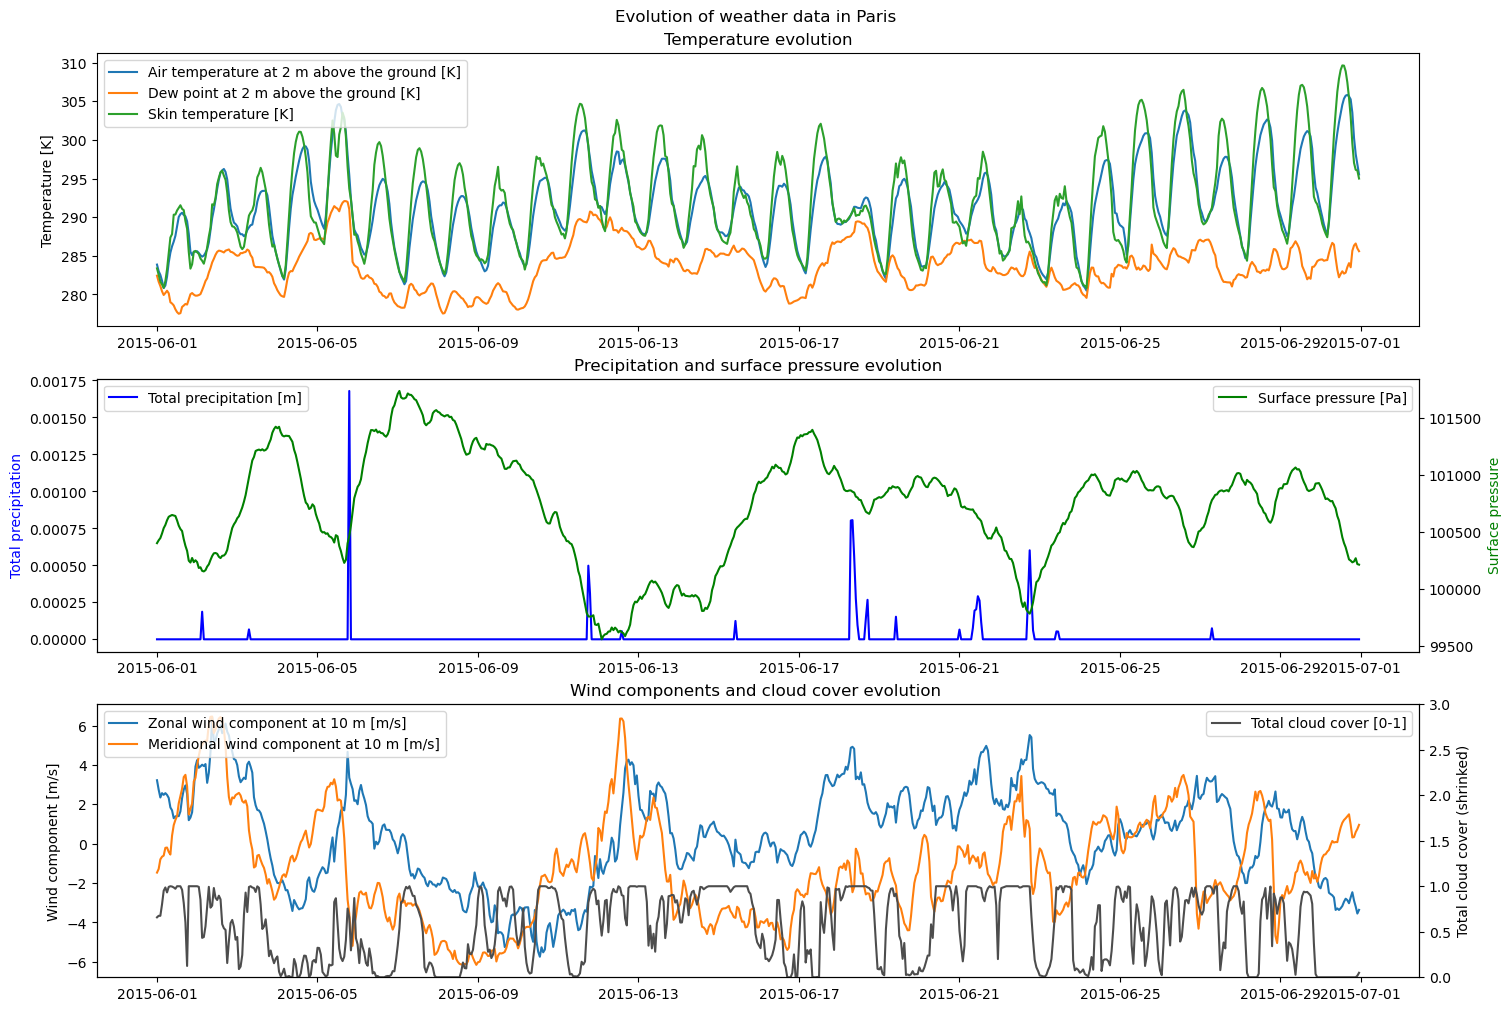

In [7]:
# Example of data for Paris June 2015
city: str = "paris"
start_date: str = "2015-06-01"
end_date: str = "2015-06-30"
paris_data_june_2015: pd.DataFrame = weather_stations_data[city].loc[
    start_date:end_date
]
display.display_weather_features(paris_data_june_2015, city)

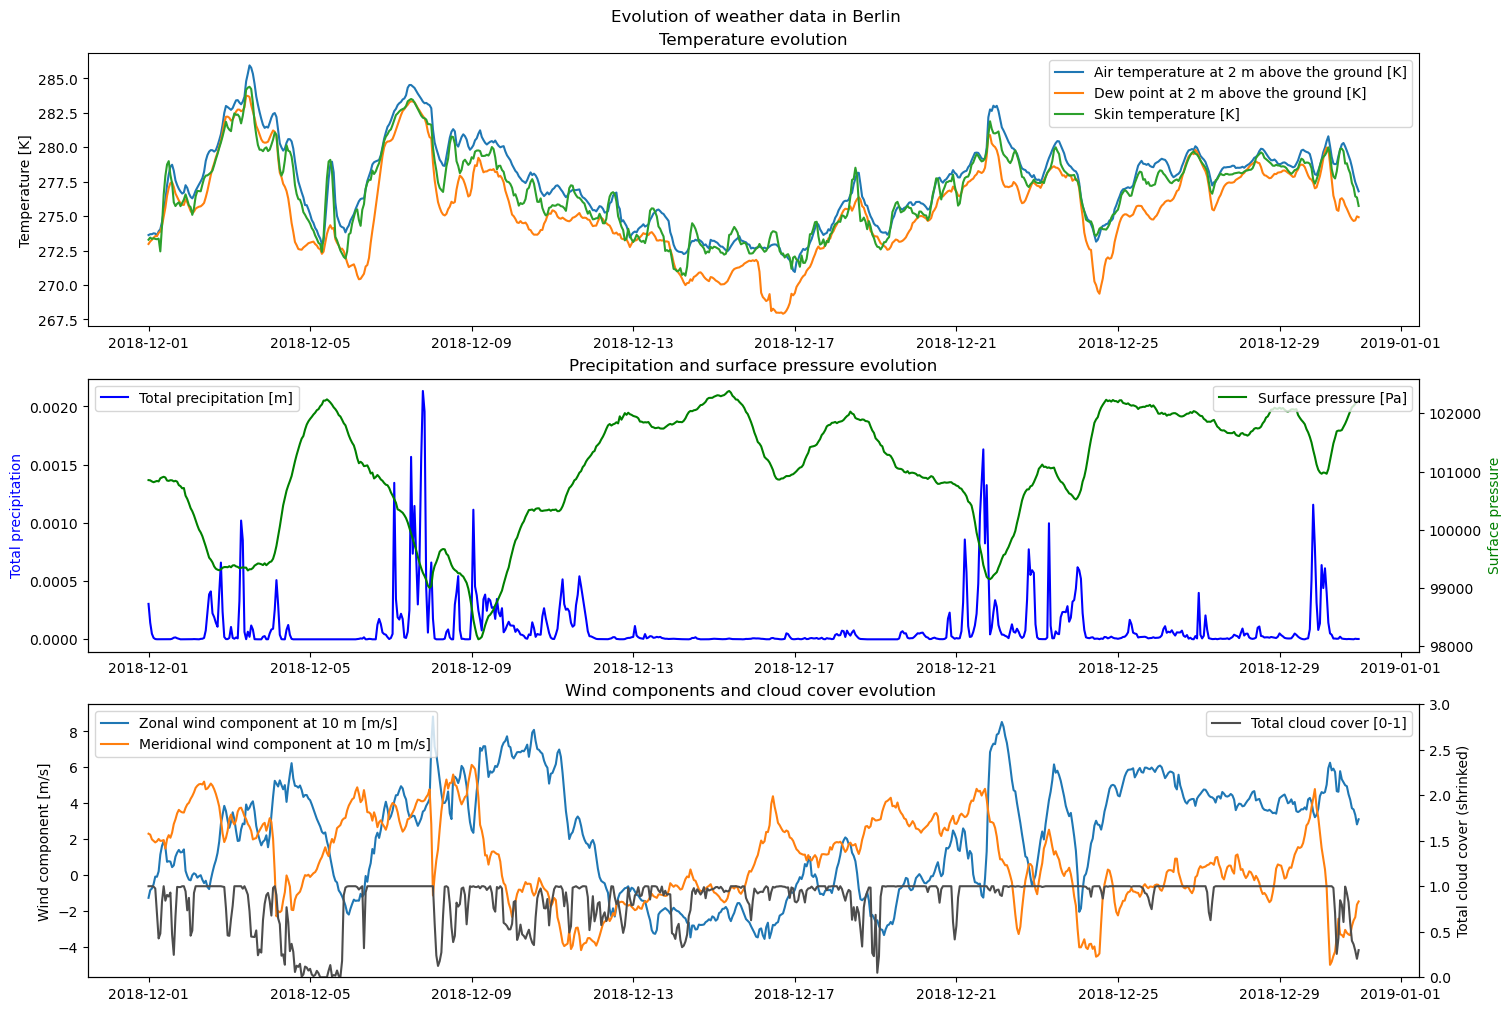

In [8]:
# Example of data for Berlin December 2018
city: str = "berlin"
start_date: str = "2018-12-01"
end_date: str = "2018-12-30"
berlin_data_dec_2018: pd.DataFrame = weather_stations_data[city].loc[
    start_date:end_date
]
display.display_weather_features(berlin_data_dec_2018, city)

<div class="alert alert-block alert-info">

**Correlation between features**: <br>
Some variables seems highly correlated, such as the 3 temperatures features(`t2m, d2m, skt`). Good sense also leads to a relation between the surface pressure and the rain (`sp`/`tp`).
</div>

### 2.3 Covariance study

The dataset is 3 dimensional, we have 2 kinds of covariance to explore: 
- the link between variables at the same time on the same city;
- the link between a variable across cities at the same time.

#### 2.3.1 Covariance between features

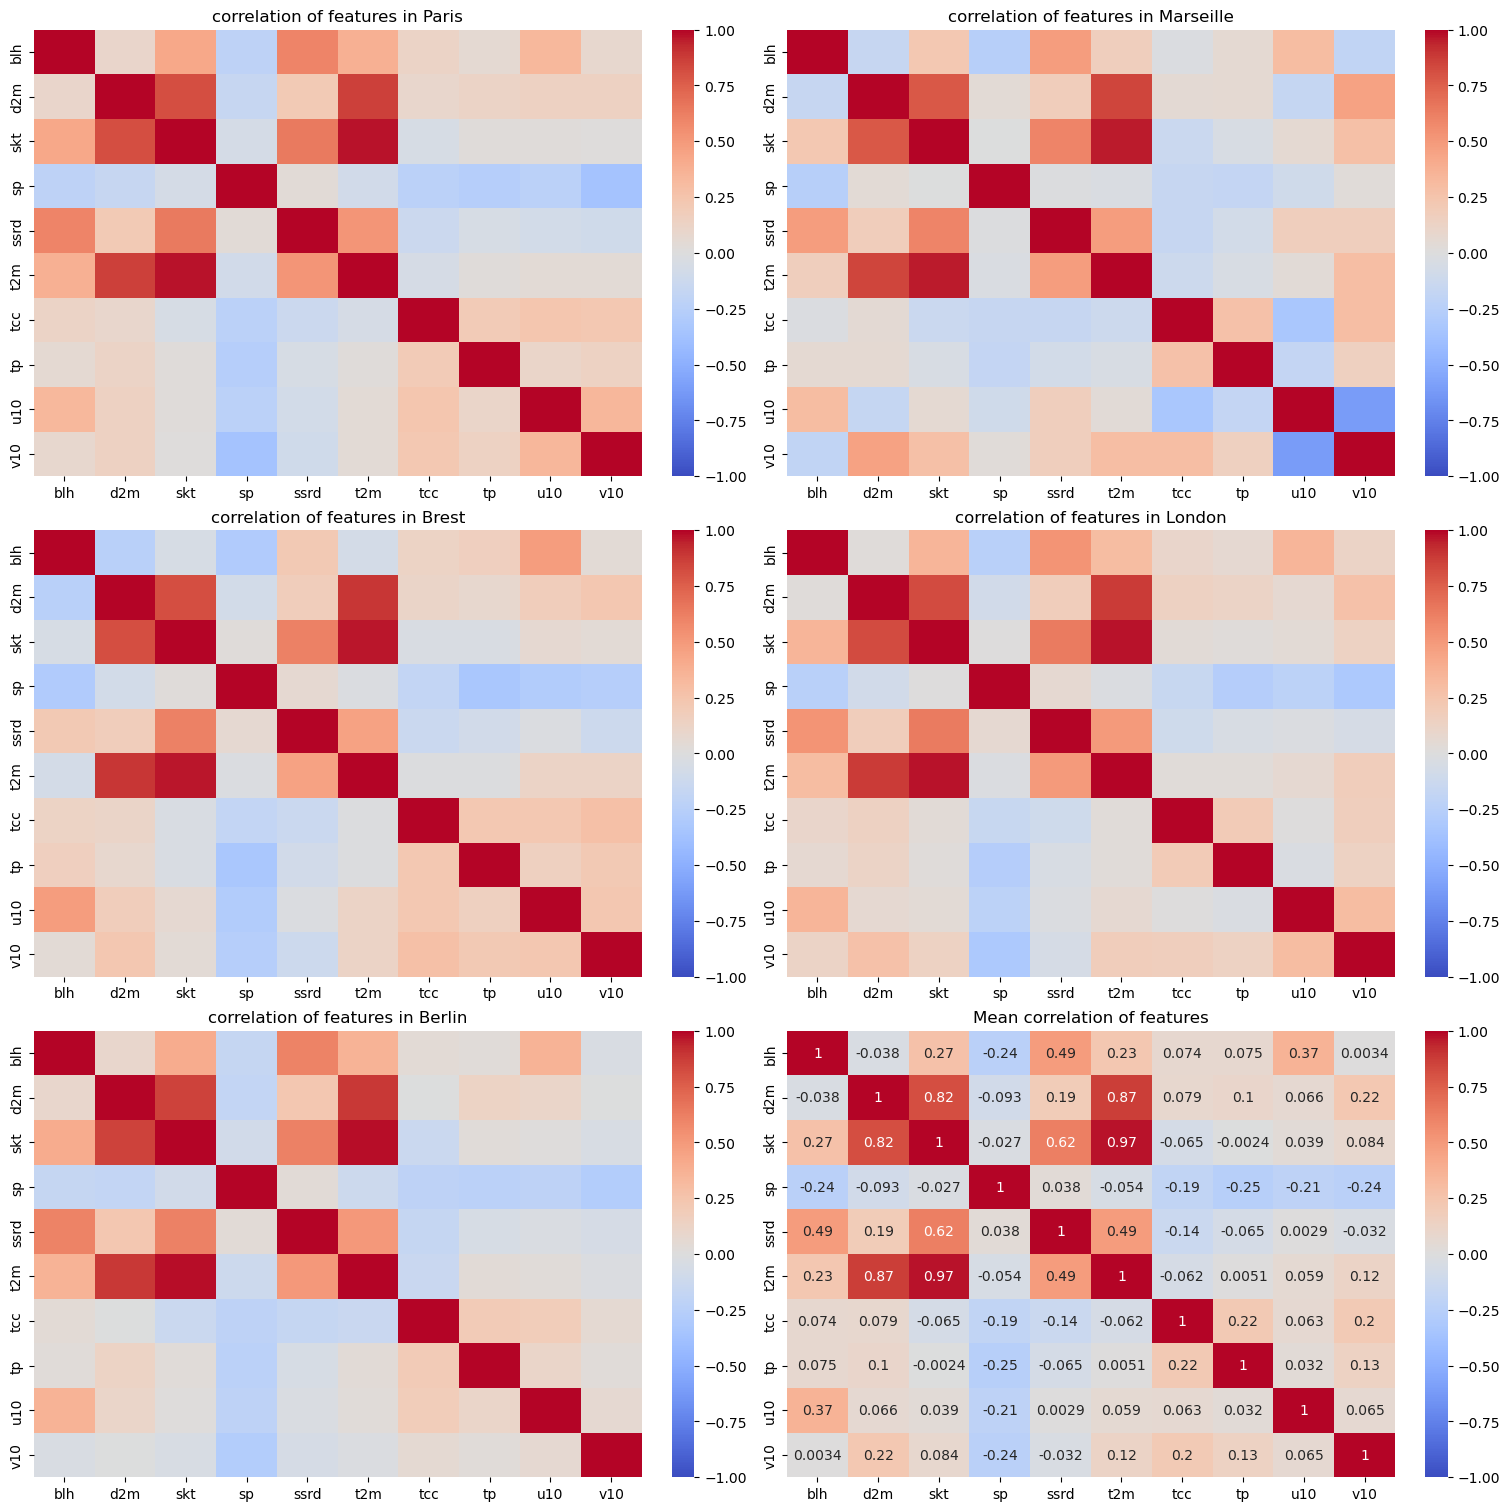

In [9]:
# Heat map of the correlation between the features for each city
fig, axs = plt.subplots(3, 2, figsize=(15, 15), layout="constrained")
axs = axs.flatten()
for city, ax in zip(cities, axs):
    sns.heatmap(
        weather_stations_data[city].corr(), cmap="coolwarm", vmin=-1.0, vmax=1.0, ax=ax
    )
    ax.set_title(f"correlation of features in {city.capitalize()}")

# Mean correlation accros the cities
sns.heatmap(
    pd.concat([weather_stations_data[city].corr() for city in cities])
    .groupby(level=0)
    .mean(),
    cmap="coolwarm",
    vmin=-1.0,
    vmax=1.0,
    ax=axs[-1],
    annot=True,
)
axs[-1].set_title("Mean correlation of features")

plt.show()

<div class="alert alert-block alert-info">

The bottom right heat map shows the correlation across the whole dataset. It confirms the correlation between the temperatures features (`t2m, d2m, skt`). However, The feature `ssrd` - that was not plot above - also have a 
strong correlation with `blh`, `skt` and `t2m`.

At -0.25, the correlation between the pressure and precipitation (`sp`/`tp`) is not relevant but, the negative sign confirms that a low pressure is needed for the rain.
</div>

#### 2.3.2 Covariance between cities

As we are expecting to predict the weather feature of Paris, we want to check if there is a correlation between the variables across the cities **at the same timestep**.

In [10]:
# To compute easily the correlation, we need to transpose the structure of the
# dataframe from cities to variables
var_datasets: dict[str, pd.DataFrame] = (
    load_data.transpose_df_dict_from_cities_to_variables(weather_stations_data)
)
# var_datasets["d2m"].head()

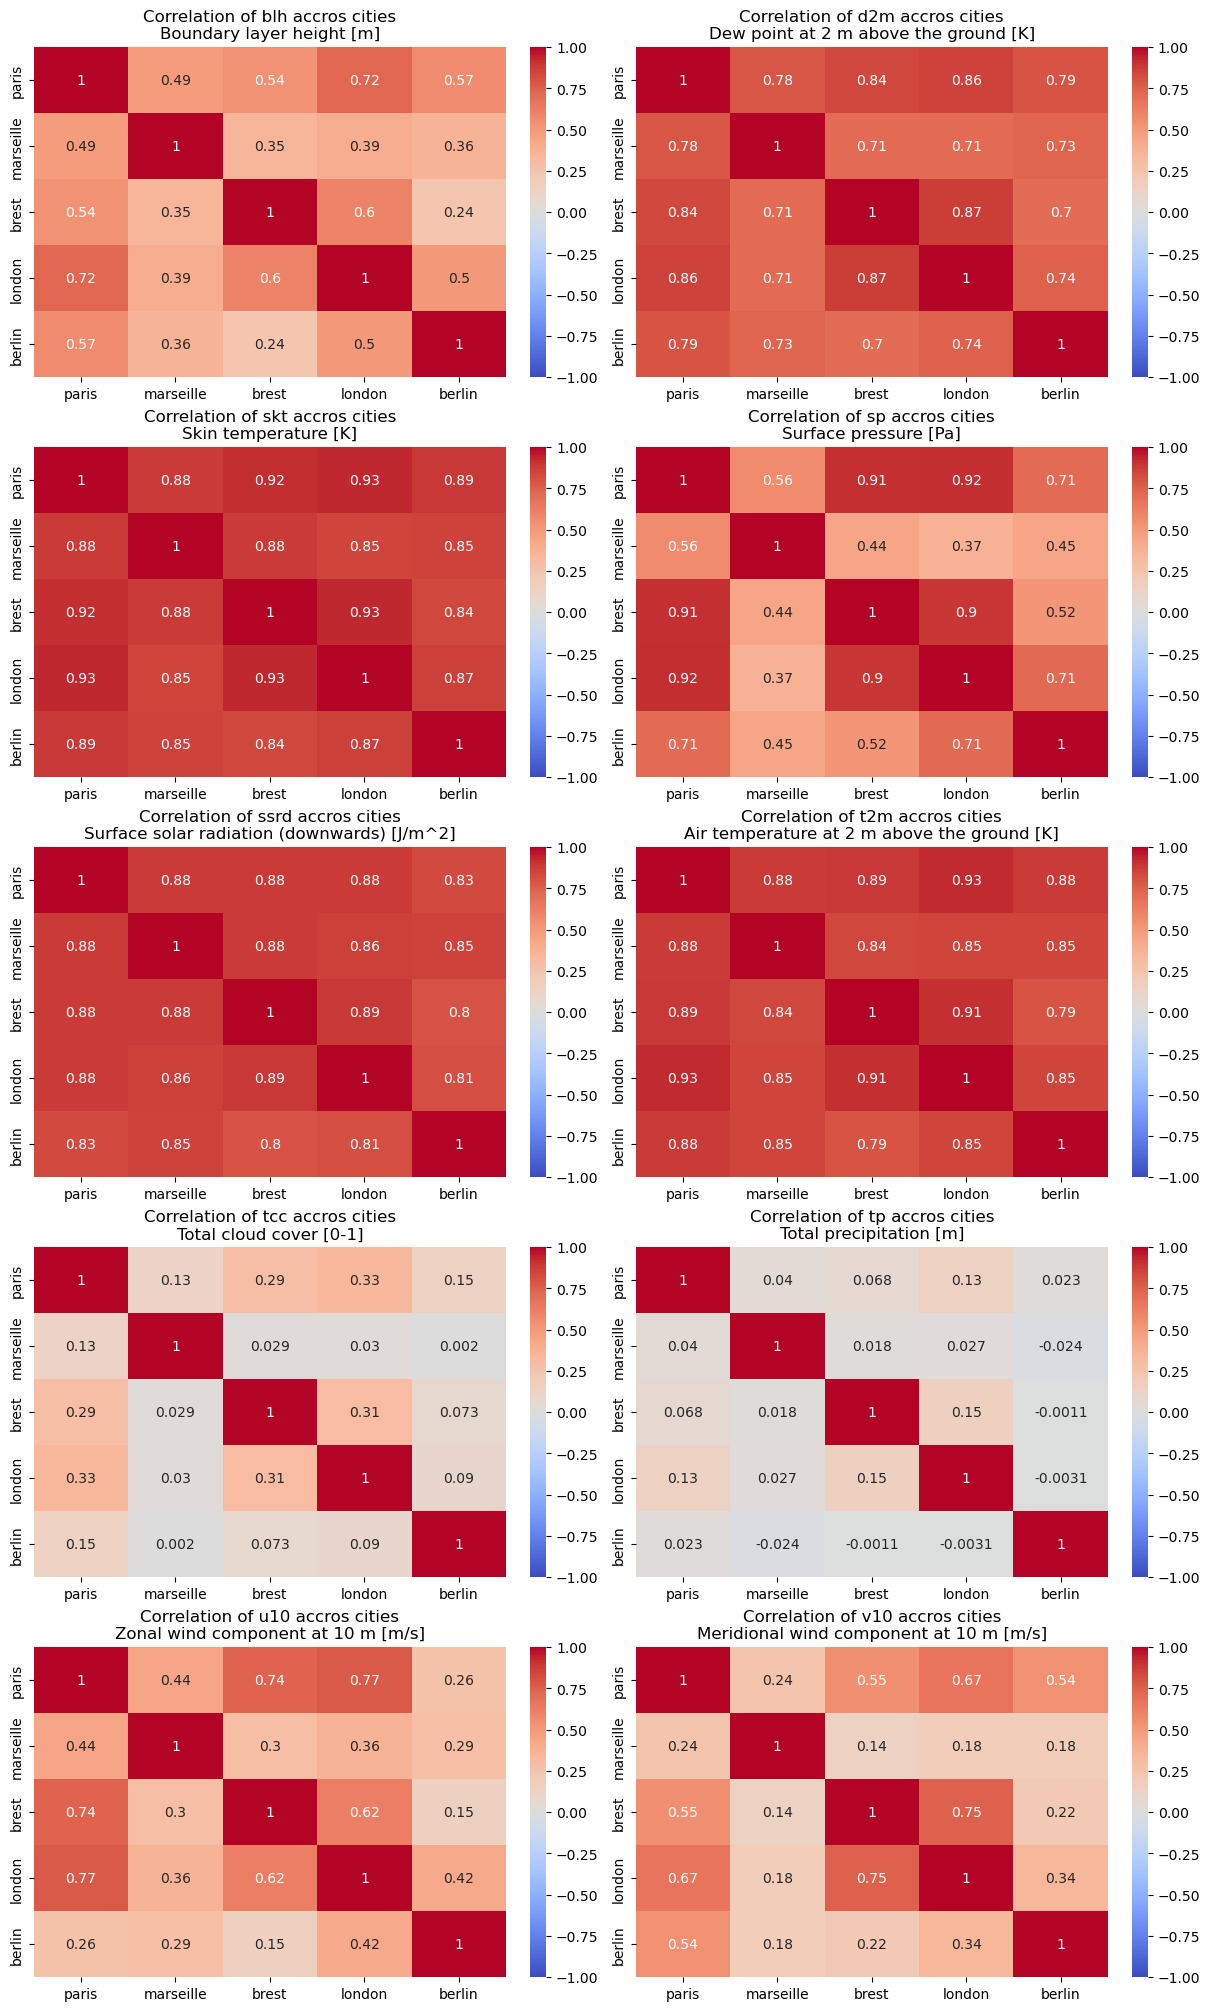

In [11]:
# Heat map of the correlation between cities for each variable
fig, axs = plt.subplots(5, 2, figsize=(12, 20), layout="constrained")
axs = axs.flatten()
for ax, (var, df) in zip(axs, var_datasets.items()):
    sns.heatmap(
        df.corr(),
        annot=True,
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        ax=ax,
    )
    ax.set_title(f"Correlation of {var} accros cities\n{display.var_legend[var]}")

<div class="alert alert-block alert-info">

**Correlation analysis**:<br>
We have different cases of correlation:
- The bright red heatmaps of the upper part confirm that temperature (`d2m, skt, t2m`) and solar radiation (`ssrd`) are highly correlated across cities.
- At the opposite, the cloud cover (`tcc`) and precipitation (`tp`) are rather local phenomenons.
- Finally, the winds (`u10, v10`) and pressure are geographically correlated: Paris is close to Brest and London, but the values for Marseille and Berlin are farther away, as the cities are.

</div>

### 2.4 Discovery of cycles in features

To discover cycles in the dataset, we will **resample the dataset to get the average value**:
- by day and plot a full year to discover seasonal patterns. (left column)
- by hour across the year to discover daily pattern. (right column)

To ease the visual comprehension, the features without cycle will be displayed on a gray background. We have selected the years 2013 to 2015.

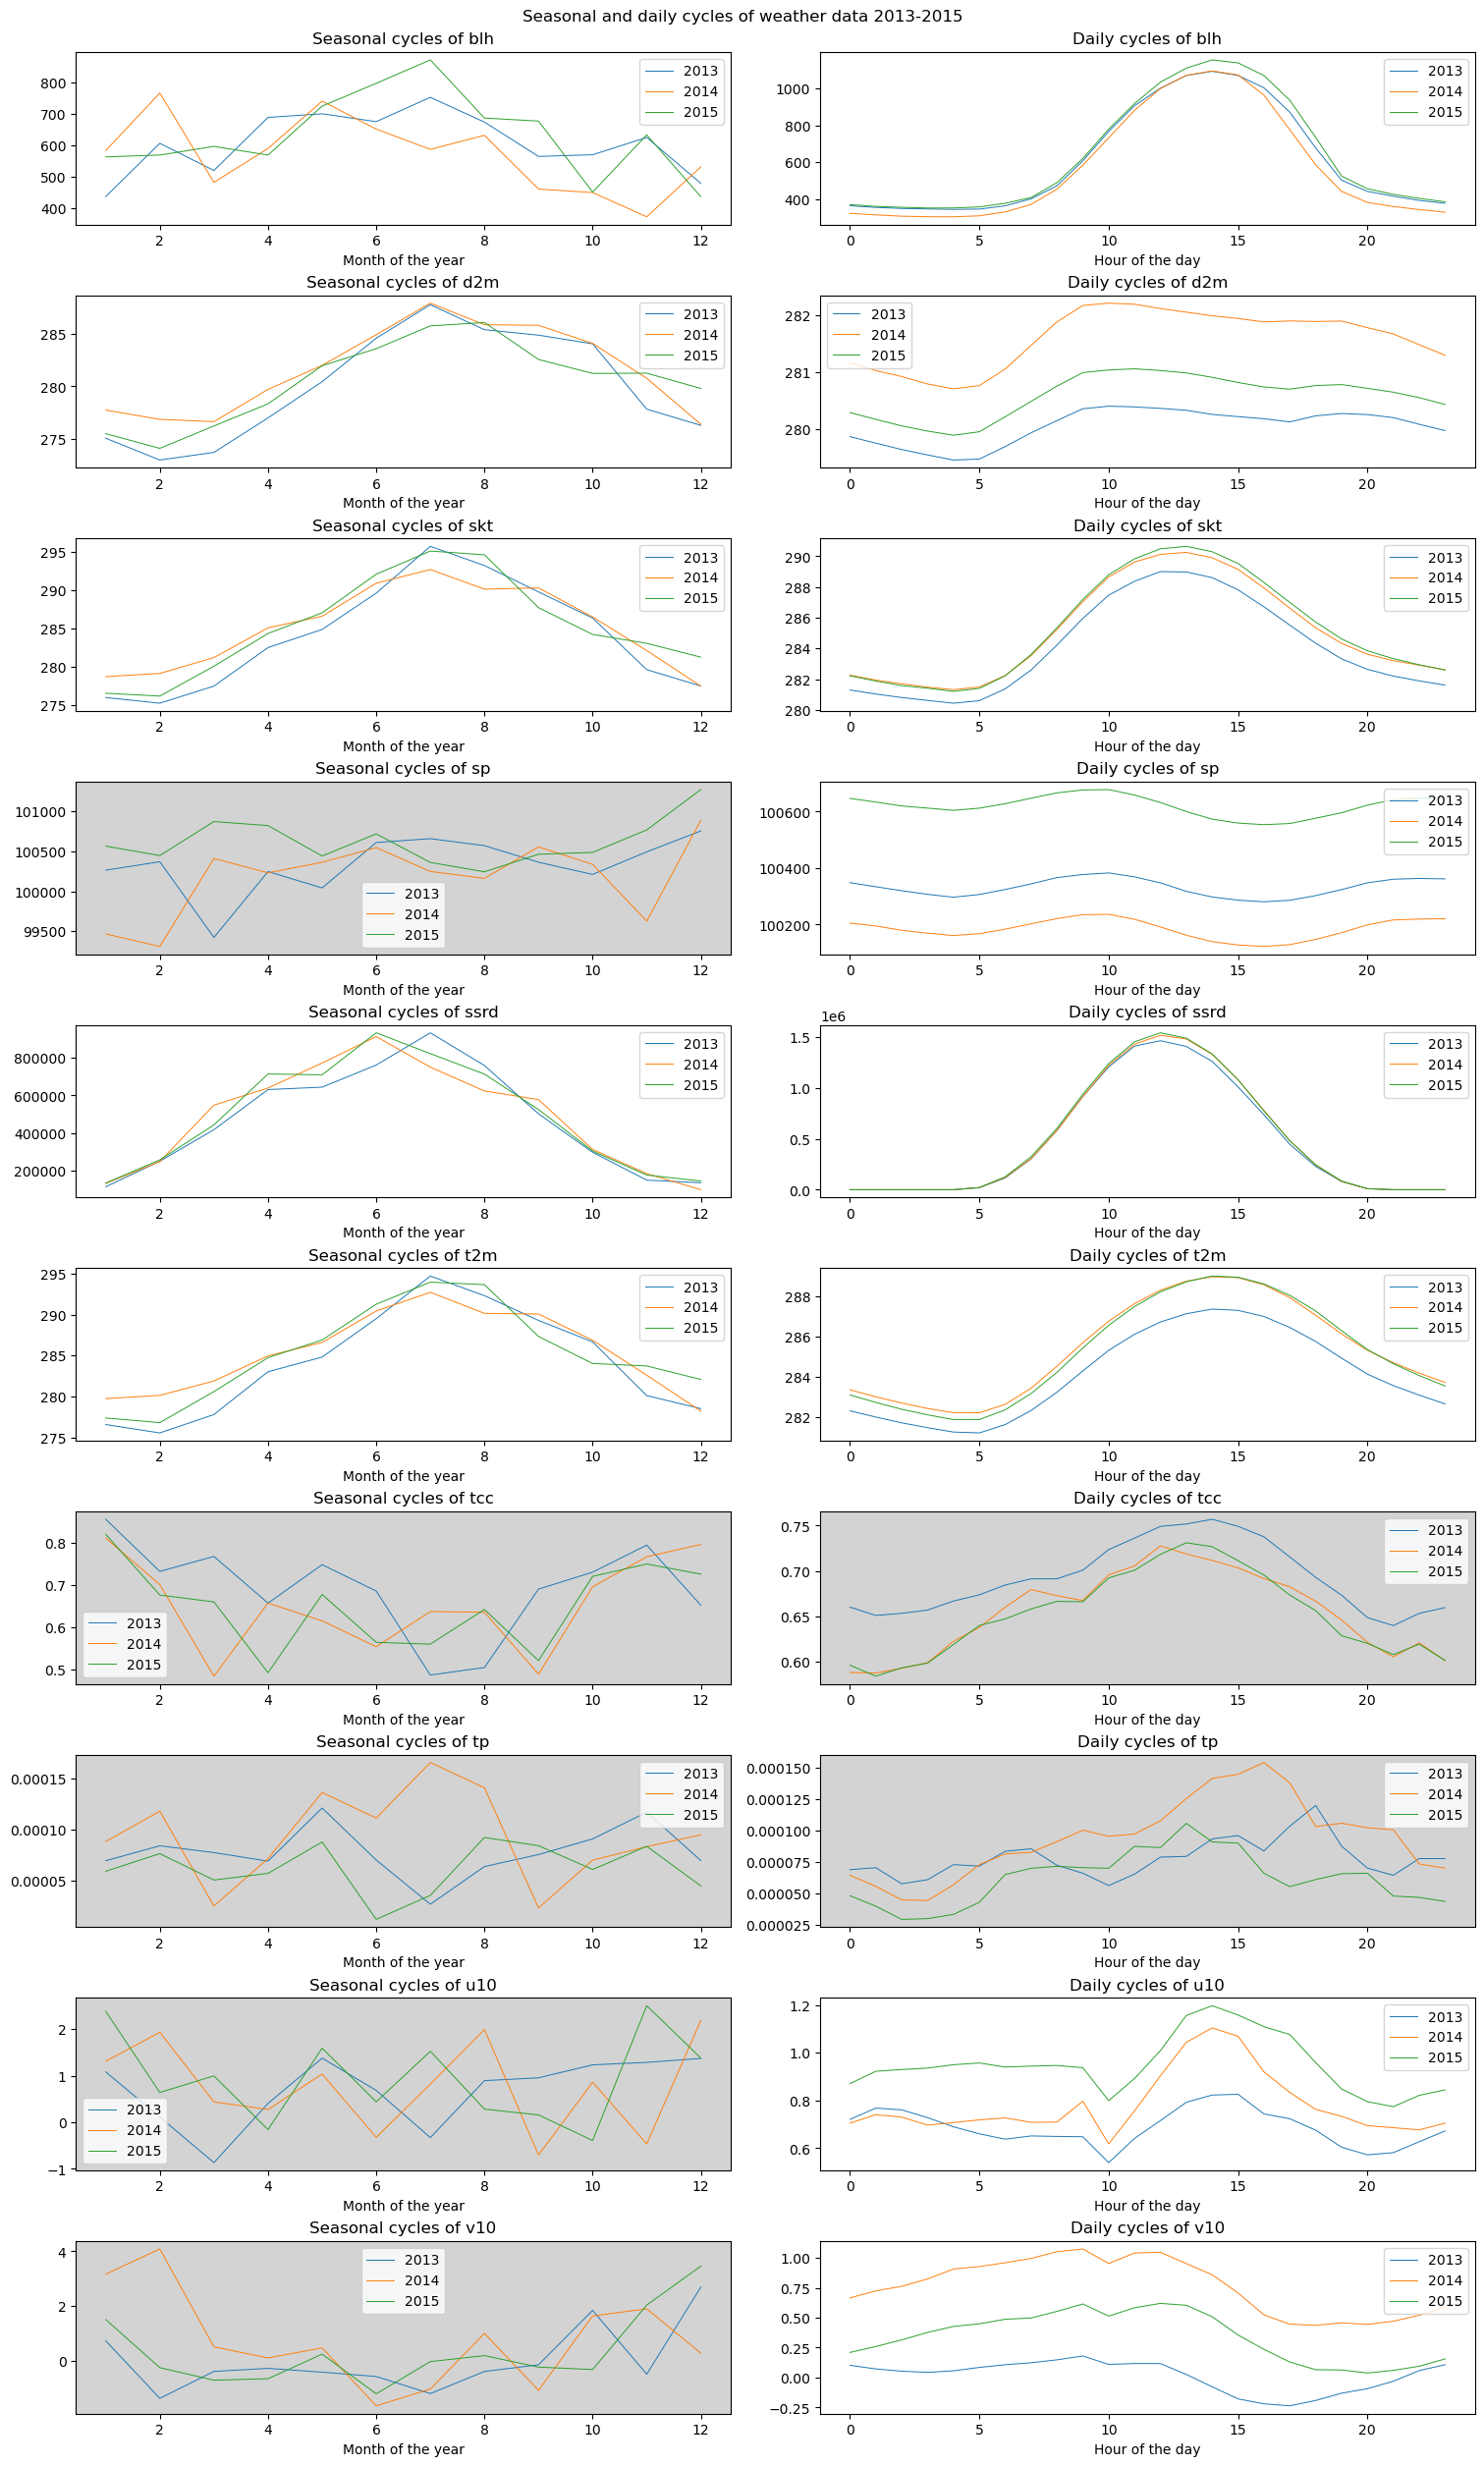

In [12]:
display.display_cycles(weather_stations_data["paris"], 2013, 2015)

<div class="alert alert-block alert-info">

**Cycle analysis**: <br>
This two kind of cycles may guide us during the **feature engineering part**.
It may be useful to feed the model with data at the same point on a previous cycle to help the prediction.

</div>

### 2.5 Reduce to a daily sample.

To speed up the computational cost, we will reduce the size dataset.
We will keep **only the 13 last years (train: 2007-2015 (~77%), test: 2016-2018 (~22%), validation: 2019 (~1%))**, and **reduce to a daily sample**. Note that variables are averaged but `tp` and `ssrd` are summed. 

Then, all datasets will be **merged in a single DataFrame gathering all variables for all cities but Paris**. This data will be saved in the `data/red_data` folder as csv files.

Finally, this X and y are split by group of years. We will get 6 Pandas DataFrame of respective size:
- X_train_red : 10 * 365 rows x 4 * 10 columns
- X_test_red : 3 * 365 rows x 4 * 10 columns
- y_train_red : 10 * 365 rows x 1 * 10 columns
- y_test_red : 3 * 365 rows x 1 * 10 columns
- X_val_red : 1 * 365 rows x 4 * 10 columns
- y_val_red : 1 * 365 rows x 1 * 10 columns


Ultimately, these datasets will be normalized after the splitting.

#### 2.5.1 Reduce the dataset and create X/y dataset

In [13]:
# Reduce to a daily sample and create X and y datasets
start_year = 2007
end_year = 2019
target_city = "paris"
save_path = Path("data", "red_data")
X_red, Y_red = load_data.create_daily_X_y_datasets(
    weather_stations_data, target_city, start_year, end_year, save_path=save_path
)

# Control the shape of the datasets
print(f"X_red shape: {X_red.shape}, y_red shape: {Y_red.shape}")

X_red shape: (4748, 40), y_red shape: (4748, 10)


#### 2.5.2 Split the dataset by dates
The two cells below aim to illustrate the steps in the split of the data but the action will be incorporated in the next step.

In [14]:
# Checkpoint: load the reduced data
save_path = Path("data", "red_data")
X_red = pd.read_csv(save_path / "X_red.csv", index_col=0, parse_dates=True)
Y_red = pd.read_csv(save_path / "Y_red.csv", index_col=0, parse_dates=True)

In [15]:
# Split the data into train, test and validation sets
end_train_date = "2016-01-01"
end_test_date = "2019-01-01"
X_train, X_test, X_val = load_data.split_train_test_val(
    X_red, end_train_date, end_test_date
)
Y_train, Y_test, Y_val = load_data.split_train_test_val(
    Y_red, end_train_date, end_test_date
)
# control the sizes
print(f"{X_train.shape=}, {X_test.shape=}, {X_val.shape=}")
print(f"{Y_train.shape=}, {Y_test.shape=}, {Y_val.shape=}")

X_train.shape=(3287, 40), X_test.shape=(1096, 40), X_val.shape=(365, 40)
Y_train.shape=(3287, 10), Y_test.shape=(1096, 10), Y_val.shape=(365, 10)


#### 2.5.3 Final dataset: **reduced and normalized** measurments

<div class="alert alert-block alert-warning">

**Quickstart**: <br>
You can start the notebook from here.
</div>

In [16]:
# Load the prepared data and normalize by variable
# Start back from the checkpoint
save_path = Path("data", "red_data")
end_train_date = "2016-01-01"
end_test_date = "2019-01-01"

X_train_rn, X_test_rn, X_val_rn, y_train_rn, y_test_rn, y_val_rn, scalers = (
    load_data.load_red_norm_data(save_path, end_train_date, end_test_date)
)
# Control the shapes
print(
    f"Shapes of datasets: \nX_train: {X_train_rn.shape}, X_test_: {X_test_rn.shape}, X_val: {X_val_rn.shape}\n"
    f"y_train: {y_train_rn.shape}, y_test: {y_test_rn.shape}, y_val: {y_val_rn.shape}"
    f" with {len(scalers)} RobustScalers"
)

Shapes of datasets: 
X_train: (3287, 40), X_test_: (1096, 40), X_val: (365, 40)
y_train: (3287, 10), y_test: (1096, 10), y_val: (365, 10) with 10 RobustScalers


<div class="alert alert-block alert-info">

This is the end of the first part of the data preparation. It is important to **keep the scalers** in memory. Because if normalized features allow comparisons of the models, it prevents any interpretability of the results.
</div>

---
## 3. Prediction of Paris Weather
Supervised regression
use cross validation with seeds to allow reproductibility.

### 3.0 Baseline: Linear regressor


Do we have different result when focusing only on one feature or are we more accurate when using all available features of the dataset?

In the following colored-gradients, we are expecting to have the most dark green / low value cells.

#### 3.0.1. Linear regressor per feature

In [17]:
# Baseline model: Linear regression for each variable
target_variables_names = list(y_train_rn.keys())

# Create a linear regression model for each variable
y_pred = []
for variable in target_variables_names:
    variable_name = variable.split("_")[1]
    model = LinearRegression()
    # Select only the corresponding columns
    related_columns = [col for col in X_train_rn.columns if variable_name in col]
    # print(f"Variable: {variable}, related columns: {related_columns}")
    model.fit(X_train_rn[related_columns], y_train_rn[variable])
    # print(f"Model fitted for {variable}:{model.coef_}")
    y_pred.append(model.predict(X_test_rn[related_columns]))
# Concatenate the predictions into a dataframe
y_pred_baseline = pd.DataFrame(
    np.array(y_pred).T, index=X_test_rn.index, columns=target_variables_names
)
# Display the result in the standardized dataframe
print(f"MSE per variable for the baseline model per variables: {model}")
baseline_mse, styled_df = display.display_mse_by_year(y_pred_baseline, y_test_rn)
styled_df


MSE per variable for the baseline model per variables: LinearRegression()


#### 3.0.2 Global linear regressor

In [18]:
# Baseline model: Linear regression for all variables
baseline_global_model = LinearRegression()
baseline_global_model.fit(X_train_rn, y_train_rn)
y_pred = baseline_global_model.predict(X_test_rn)
# load into a dataframe
y_pred_baseline_global = pd.DataFrame(
    y_pred, index=X_test_rn.index, columns=target_variables_names
)
# Display the result in the standardized dataframe
print(f"MSE per variable for the baseline model global: {baseline_global_model}")
baseline_global_mse, styled_df = display.display_mse_by_year(
    y_pred_baseline_global, y_test_rn
)
styled_df

MSE per variable for the baseline model global: LinearRegression()


In [19]:
print("Base line vs global model, reduction of MSE per variable")
_, styled_df = display.display_delta(baseline_mse, baseline_global_mse)
styled_df

Base line vs global model, reduction of MSE per variable


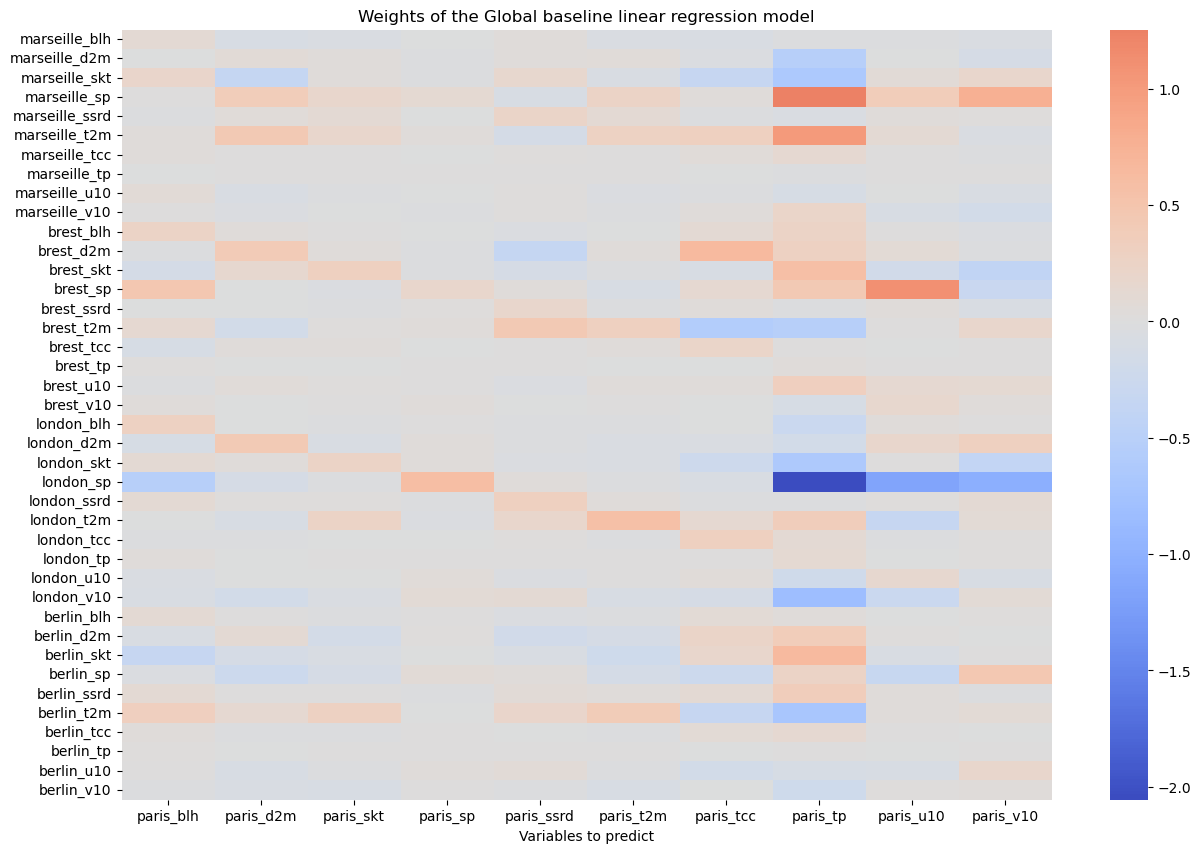

In [20]:
# Explanability -> show the weights
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(
    baseline_global_model.coef_.T,
    ax=ax,
    cmap="coolwarm",
    center=0,
    xticklabels=target_variables_names,
    yticklabels=X_train_rn.columns,
)
ax.set_title("Weights of the Global baseline linear regression model")
ax.set_xlabel("Variables to predict")

plt.show()

<div class="alert alert-block alert-info">

**Baseline model**:<br>
Our global baseline model is a `LinearRegression` fitted on all $40$ available features that predicts the $10$ features of Paris in one pass. It uses only $10 \times 40+10 = 50$ coefficients and these coefficients are computed nearly instantaneously.

The use of all features improved the prediction of the `tp` variable. The heatmap above show that the precipitation prediction relies on nearly all other features. In comparison with the $`sp`$ that need only the value in London.

**$\Rightarrow$ The global model is our new baseline model.**

</div>

#### Visualize the predictions of the first month

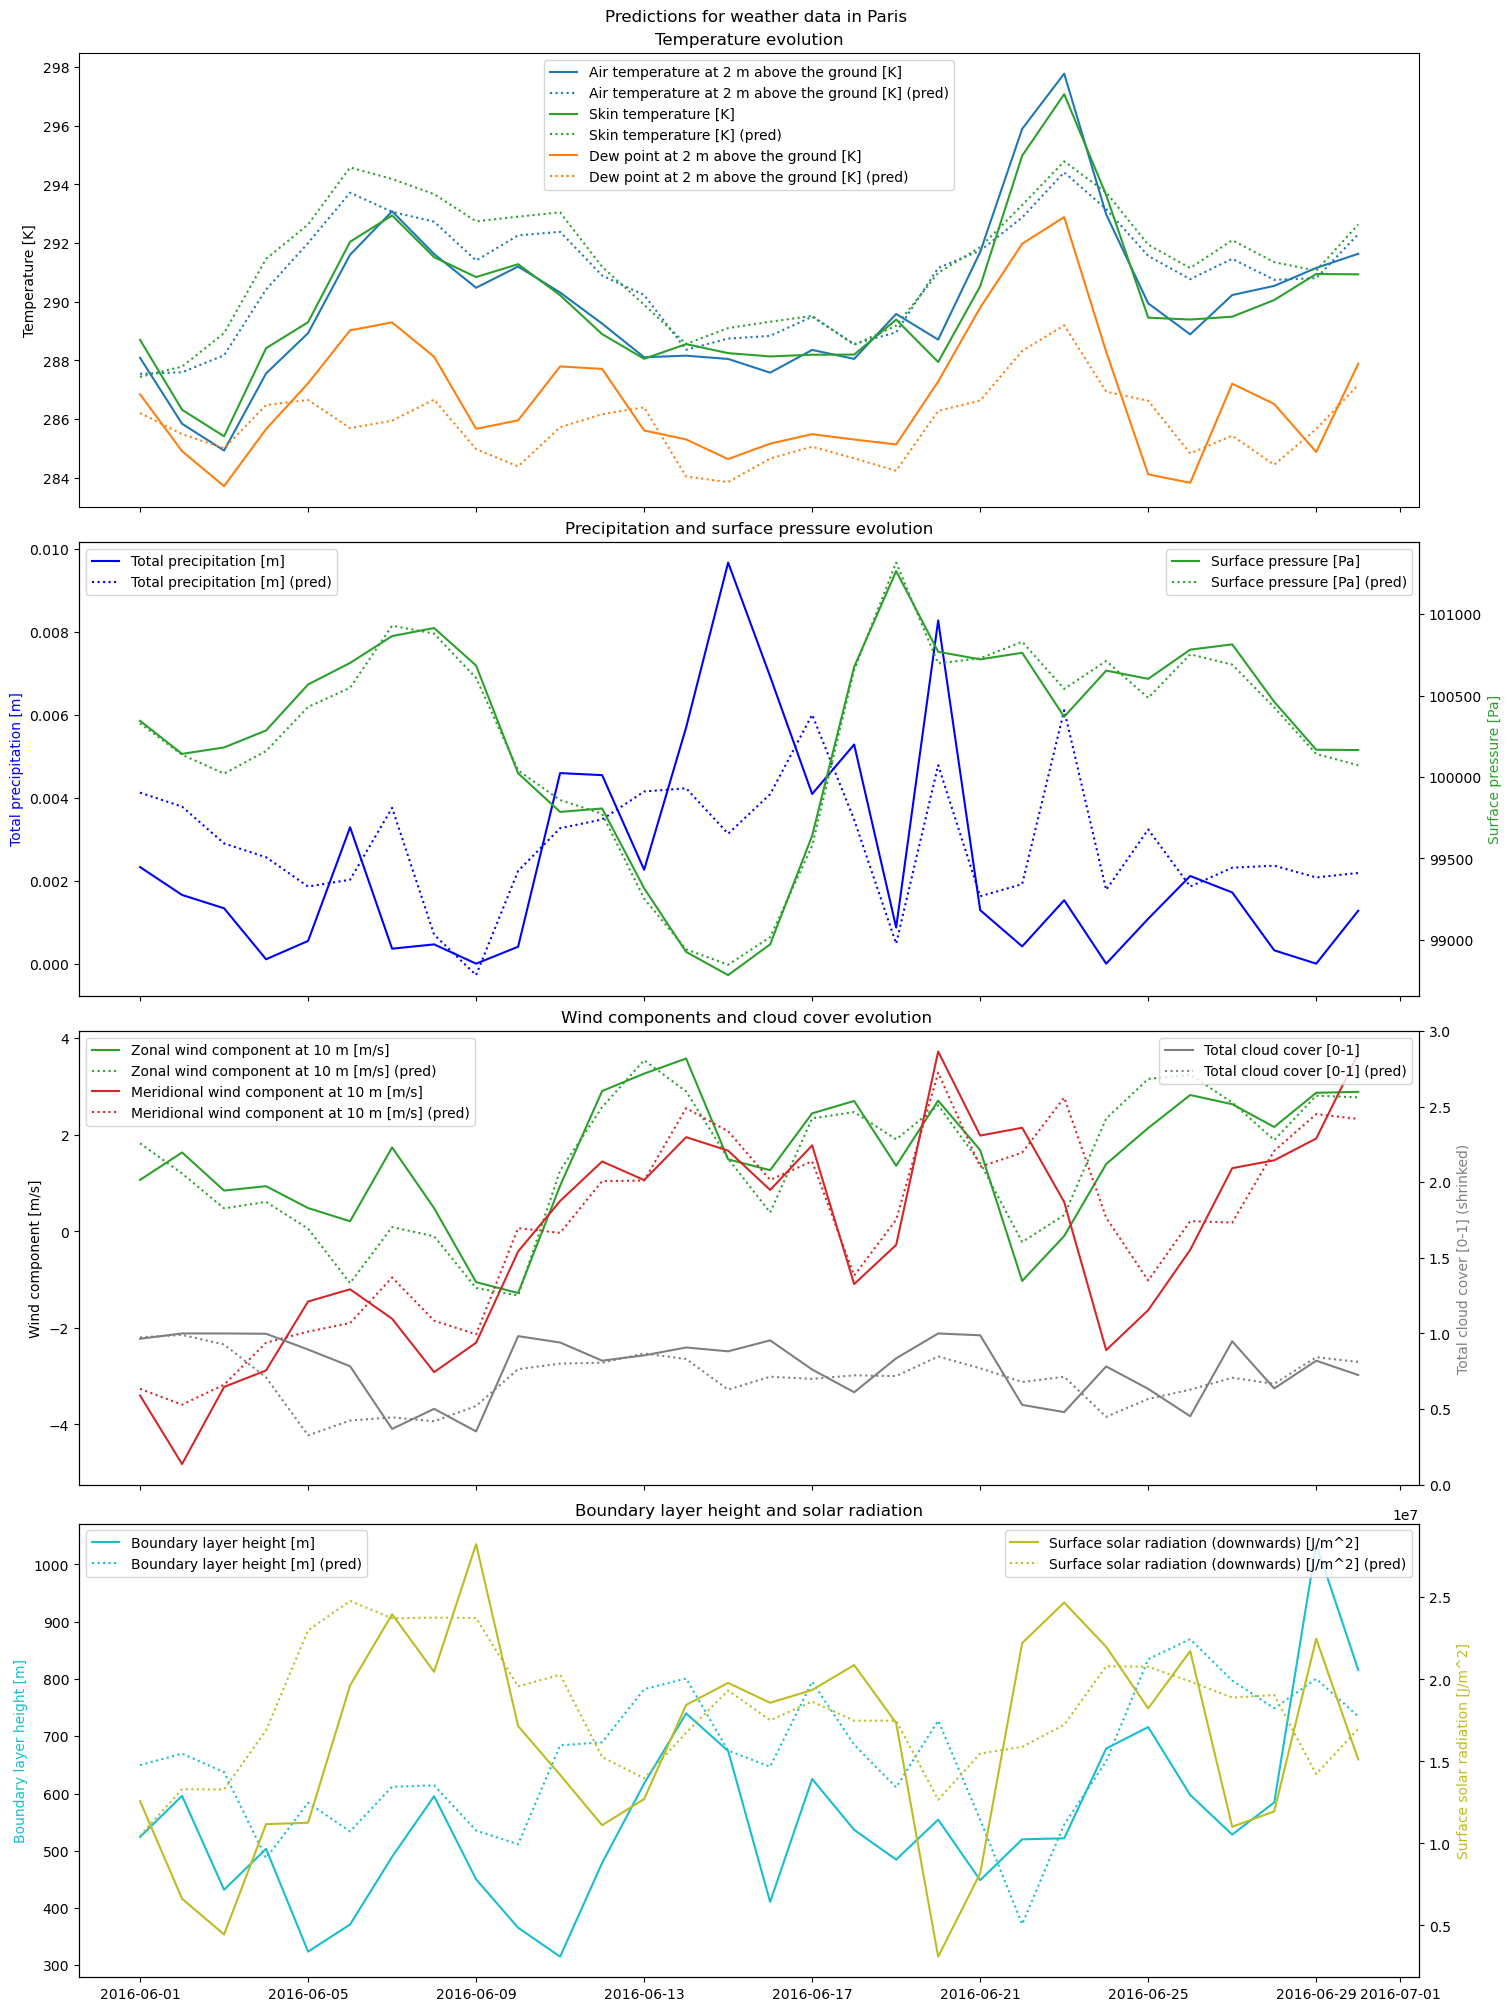

In [21]:
# Display the predictions and the actual values for the first 30 days of the test set = june 2016
display.display_predictions_with_actual(
    y_pred_baseline_global,
    y_test_rn,
    scalers,
    from_date="2016-06-01",
    to_date="2016-06-30",
)

<div class="alert alert-block alert-info">

**Prediction visualisation**:<br>
Our global `LinearRegression` predicts coherent values for each feature. But the predicted dot lines are still far from the actual values. There is still some work to do.
</div>

### 3.1 Model 1: Linear Lasso


In [22]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning with GridSearchCV
alpha_values = np.logspace(-4, 1, 50)

lasso = Lasso(max_iter=10000)
grid = GridSearchCV(
    estimator=lasso,
    param_grid={"alpha": alpha_values},
    scoring="neg_mean_squared_error",
    cv=10,
    n_jobs=-1,
)

grid.fit(X_train_rn, y_train_rn)

GridSearchCV(cv=10, estimator=Lasso(max_iter=10000), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 1.26485522e-04, 1.59985872e-04, 2.02358965e-04,
       2.55954792e-04, 3.23745754e-04, 4.09491506e-04, 5.17947468e-04,
       6.55128557e-04, 8.28642773e-04, 1.04811313e-03, 1.32571137e-03,
       1.67683294e-03, 2.12095089e-03, 2.68269580e-03, 3.39322177e-03,
       4.29193426e-03, 5.42867...
       7.19685673e-02, 9.10298178e-02, 1.15139540e-01, 1.45634848e-01,
       1.84206997e-01, 2.32995181e-01, 2.94705170e-01, 3.72759372e-01,
       4.71486636e-01, 5.96362332e-01, 7.54312006e-01, 9.54095476e-01,
       1.20679264e+00, 1.52641797e+00, 1.93069773e+00, 2.44205309e+00,
       3.08884360e+00, 3.90693994e+00, 4.94171336e+00, 6.25055193e+00,
       7.90604321e+00, 1.00000000e+01])},
             scoring='neg_mean_squared_error')

In [23]:
# Select the best model
best_lasso_model = grid.best_estimator_

# Train the best Lasso model on the training set
best_lasso_model.fit(X_train_rn, y_train_rn)

# Make predictions on the test set
y_pred_lasso = best_lasso_model.predict(X_test_rn)

# Load predictions into a DataFrame
y_pred_lasso_df = pd.DataFrame(
    y_pred_lasso, index=X_test_rn.index, columns=target_variables_names
)

# Evaluate the model
lasso_mse, styled_df = display.display_mse_by_year(y_pred_lasso_df, y_test_rn)
print("Mean Squared Error (MSE) for Lasso Regression:")
styled_df

Mean Squared Error (MSE) for Lasso Regression:


In [24]:
# Compare the Lasso model with the baseline model
print("Baseline vs Lasso model, reduction of MSE per variable")
_, comparison_styled_df = display.display_delta(baseline_global_mse, lasso_mse)
comparison_styled_df

Baseline vs Lasso model, reduction of MSE per variable


In [25]:
# Display improvement
overall_improvement = (
    baseline_global_mse.loc["all"].mean() - lasso_mse.loc["all"].mean()
)
print(
    f"Overall MSE improved by {overall_improvement:.5f} points with Lasso Regression."
)

Overall MSE improved by 0.00075 points with Lasso Regression.


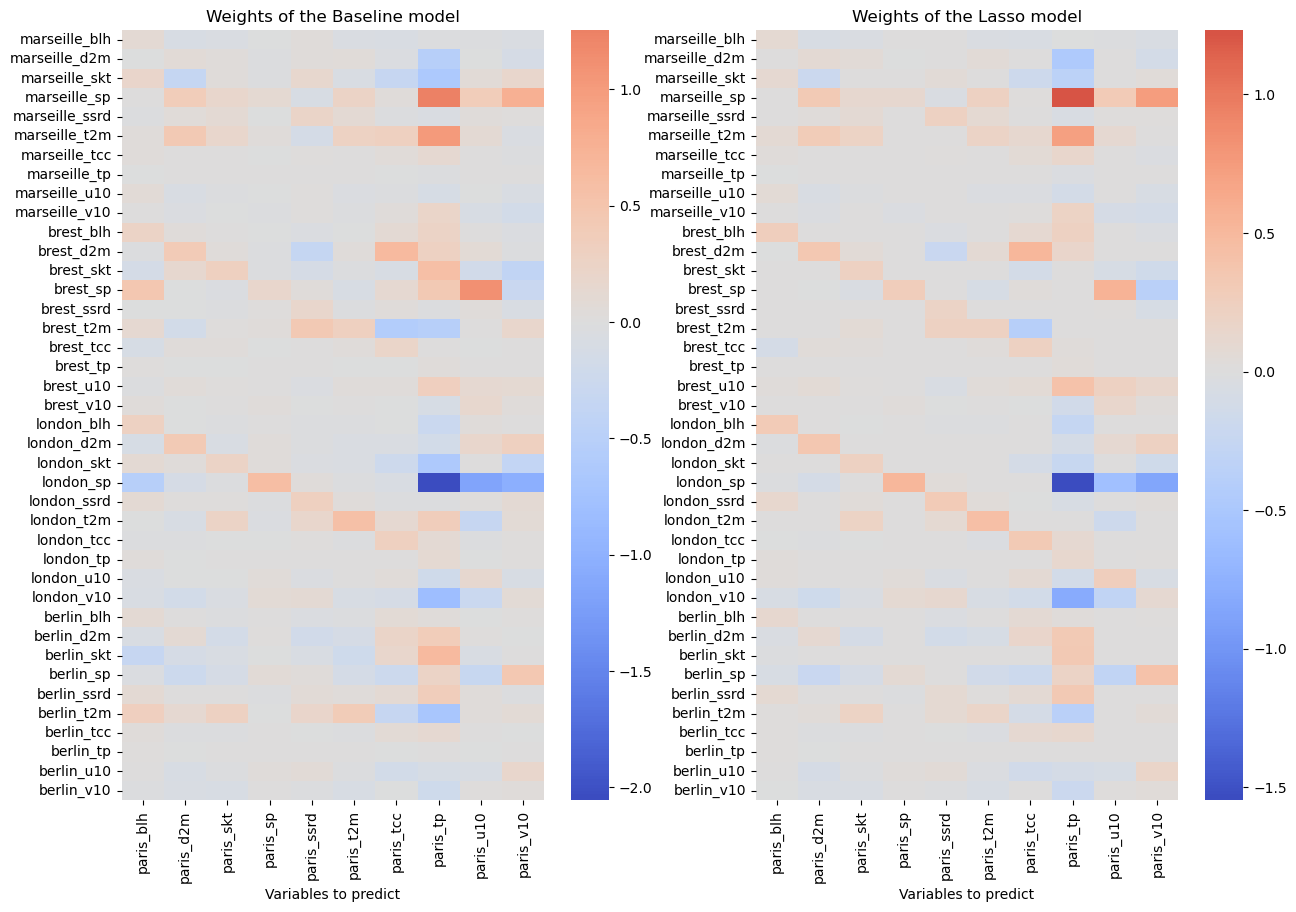

In [26]:
# Explanability -> show the weights
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
sns.heatmap(
    baseline_global_model.coef_.T,
    ax=ax[0],
    cmap="coolwarm",
    center=0,
    xticklabels=target_variables_names,
    yticklabels=X_train_rn.columns,
)
ax[0].set_title("Weights of the Baseline model")
ax[0].set_xlabel("Variables to predict")

sns.heatmap(
    best_lasso_model.coef_.T,
    ax=ax[1],
    cmap="coolwarm",
    center=0,
    xticklabels=target_variables_names,
    yticklabels=X_train_rn.columns,
)
ax[1].set_title("Weights of the Lasso model")
ax[1].set_xlabel("Variables to predict")

plt.show()

<div class="alert alert-block alert-info">

**Model 1: Lasso Regression**:<br>
The fine-tuned `Lasso` regression achieved a small overall improvement, reducing the **MSE by 0.00075 points** compared to the baseline. It performed best on **wind variables (u10, v10)** and showed mixed results on more unpredictable variables like **precipitation (tp)**.

While `Lasso`'s regularization proved effective, its limitations suggest the need for a more robust model. Only few featrues were selected by the regressor. So the regularization with the lasso did not improve a lot. Most of the coefficients are already close to 0.

**$\Rightarrow$ The next model will be a tree-based approach (e.g., `RandomForestRegressor` or `XGBoost`), which excels at capturing non-linear relationships and interactions for further performance improvements.**

</div>

### 3.2 Model 2 : Tree-based models

#### Model 3.2.1 : RandomForestRegressor

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

if RETRAIN_MODELS:
    rf_model = RandomForestRegressor(random_state=1)
    parameter_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, 30],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "criterion": ["squared_error"],
    }
    # Train the model
    grid = GridSearchCV(
        estimator=rf_model,
        param_grid=parameter_grid,
        scoring="neg_mean_squared_error",
        cv=10,
        n_jobs=-1,
    )
    grid.fit(X_train_rn, y_train_rn)
    # Select the best model
    best_rf_model = grid.best_estimator_
    best_rf_model.fit(X_train_rn, y_train_rn)

    # save the model with joblib
    joblib.dump(best_rf_model, SAVE_MODELS_PATH / "best_rf_model.joblib")
else:
    # Load the model from disk
    assert (
        SAVE_MODELS_PATH / "best_rf_model.joblib"
    ).exists(), (
        f'No random forest model found at {SAVE_MODELS_PATH / "best_rf_model.joblib"}'
    )
    best_rf_model = joblib.load(SAVE_MODELS_PATH / "best_rf_model.joblib")

In [28]:
print("RF parameters:", best_rf_model.get_params())
# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test_rn)

# Load predictions into a DataFrame
y_pred_rf_df = pd.DataFrame(
    y_pred_rf, index=X_test_rn.index, columns=target_variables_names
)
rf_mse, styled_rf = display.display_mse_by_year(y_pred_rf_df, y_test_rn)
print("MSE for Random Forest Regressor:")
styled_rf

RF parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
MSE for Random Forest Regressor:


In [29]:
# Compare the Random Forest model with the baseline model
print("Baseline vs Random Forest, reduction of MSE per variable")
_, comparison_rf = display.display_delta(baseline_global_mse, rf_mse)
comparison_rf

Baseline vs Random Forest, reduction of MSE per variable


<div class="alert alert-block alert-info">

**Model 2.1 : Optimized Random Forest Regressor**:<br>
After hyperparameter tuning, the `RandomForestRegressor` showed only marginal improvement, with an **overall MSE still worse than the baseline model**.  
The overall results remain unsatisfactory.

**$\Rightarrow$ The next step will explore `XGBoost` to leverage its gradient boosting capabilities for better performance.**

</div>

#### 3.2.2 Model 2.2: XGBoost

In [30]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBRegressor(random_state=1, objective="reg:squarederror")

# Train the model
xgb_model.fit(X_train_rn, y_train_rn)
# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_rn)

# Evaluate the model
y_pred_xgb_df = pd.DataFrame(
    y_pred_xgb, index=X_test_rn.index, columns=target_variables_names
)
xgb_mse, styled_xgb = display.display_mse_by_year(y_pred_xgb_df, y_test_rn)
print("MSE for XGBoost:")
styled_xgb


MSE for XGBoost:


In [31]:
# Compare the XGBoost model with the baseline model
# Display improvement
overall_improvement = baseline_global_mse.loc["all"].mean() - xgb_mse.loc["all"].mean()
print(f"Overall MSE improved by {overall_improvement:.5f} points with XGBoost.")
print("Baseline vs XGBoost, reduction of MSE per variable")
_, comparison_xgb = display.display_delta(baseline_global_mse, xgb_mse)
comparison_xgb

Overall MSE improved by -0.02392 points with XGBoost.
Baseline vs XGBoost, reduction of MSE per variable


<div class="alert alert-block alert-info">

**Model 2.2: XGBoost**:<br>
The base `XGBoost` model underperformed.  
It struggled particularly with the variable **tp** in 2017, indicating the need for further tuning to better handle such challenging variables.

**$\Rightarrow$ The next step will focus on fine-tuning `XGBoost` for improved performance.**

</div>

In [32]:
# Hyperparameter tuning with GridSearchCV
if RETRAIN_MODELS:
    param_grid_xgb = {
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 6],
        "n_estimators": [100, 300],
        "subsample": [0.8],
    }

    grid_search_xgb = GridSearchCV(
        estimator=xgb.XGBRegressor(random_state=42, objective="reg:squarederror"),
        param_grid=param_grid_xgb,
        cv=3,
        n_jobs=-1,
        scoring="neg_mean_squared_error",
    )
    grid_search_xgb.fit(X_train_rn, y_train_rn)

    # Best XGBoost model
    best_xgb_model = grid_search_xgb.best_estimator_
    print(f"Best XGBoost parameters: {grid_search_xgb.best_params_}")
    # Save the best model
    joblib.dump(best_xgb_model, SAVE_MODELS_PATH / "best_xgb_model.joblib")
else:
    # Load the model from disk
    assert (
        SAVE_MODELS_PATH / "best_xgb_model.joblib"
    ).exists(), (
        f'No XGBoost model found at {SAVE_MODELS_PATH / "best_xgb_model.joblib"}'
    )
    best_xgb_model = joblib.load(SAVE_MODELS_PATH / "best_xgb_model.joblib")

# retrain the best model
best_xgb_model.fit(X_train_rn, y_train_rn)
y_pred_xgb_optimized = best_xgb_model.predict(X_test_rn)
y_pred_xgb_opt_df = pd.DataFrame(
    y_pred_xgb_optimized, index=X_test_rn.index, columns=target_variables_names
)
xgb_opt_mse, styled_xgb_opt = display.display_mse_by_year(y_pred_xgb_opt_df, y_test_rn)
print("MSE for Optimized XGBoost:")
styled_xgb_opt

MSE for Optimized XGBoost:


In [33]:
# Display improvement
overall_improvement = (
    baseline_global_mse.loc["all"].mean() - xgb_opt_mse.loc["all"].mean()
)
print(
    f"Overall MSE improved by {overall_improvement:.5f} points with Optimized XGBoost."
)

# Compare the XGBoost Best model with the baseline model
print("Baseline vs Optimized XGBoost, reduction of MSE per variable")
_, comparison_xgb_opt = display.display_delta(baseline_global_mse, xgb_opt_mse)
comparison_xgb_opt

Overall MSE improved by -0.00116 points with Optimized XGBoost.
Baseline vs Optimized XGBoost, reduction of MSE per variable


<div class="alert alert-block alert-info">

**Model 2.2b: Optimized XGBoost**:<br>
The optimized `XGBoost` model showed minimal improvement but still performed worse than the baseline.

</div>

<div class="alert alert-block alert-info">

**General Conclusion on Tree-Based Models**:<br>

The exploration of tree-based models, including `RandomForestRegressor` and `XGBoost`, revealed limitations in their ability to outperform the baseline model.   
Despite attempts at hyperparameter tuning, the overall MSE for both models showed only marginal or negative improvements, with significant errors persisting for challenging variables like **tp**.

Tree-based models excel at capturing non-linear relationships, but their application to this dataset has been less effective, possibly due to the specific nature of the data or the need for more advanced feature engineering.

**$\Rightarrow$ Let's explore other models such as SVR or DL models.**

</div>


### 3.3 Model 3 : SVR

Support Vector Regression (SVR) is a type of Support Vector Machine (SVM) that is used for regression tasks. While SVM is typically used for classification, SVR adapts the principles of SVM to predict continuous values. The goal is to find a hyperplane that best fits the data points. Unlike linear regression, SVR tries to fit the best line within a threshold value, The Epsilon (ε) Margin. SVR introduces an epsilon margin of tolerance where no penalty is given to errors. This means that the model tries to fit the data points within a tube of width 2ε.


In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

if RETRAIN_MODELS:
    # train with a grid search the best SVR model for each variable
    parameter_grid = {
        "kernel": ["rbf"],
        "epsilon": np.logspace(-2, 2, 20),
        "C": np.logspace(-1, 2, 20),
    }
    # Create a grid search regression model for each variable
    y_pred = []
    svr_models_per_variable = {}
    for variable in target_variables_names:
        variable_name = variable.split("_")[1]
        model = GridSearchCV(SVR(), param_grid=parameter_grid, n_jobs=-1, refit=True)
        # Select only the corresponding columns
        related_columns = [col for col in X_train_rn.columns if variable_name in col]
        print(f"Fit on variable: {variable}, with columns: {related_columns}")
        model.fit(X_train_rn[related_columns], y_train_rn[variable].to_numpy())
        svr_models_per_variable[variable] = model
        # save the models with joblib
        joblib.dump(model, SAVE_MODELS_PATH / f"svr_{variable}.joblib")
        y_pred.append(model.predict(X_test_rn[related_columns]))

else:
    # Load the models from disk
    assert (
        SAVE_MODELS_PATH.exists()
    ), "No saved_models folder found, set RETRAIN_MODELS to True on top on the notebook"

    svr_models_per_variable = {}
    for variable in target_variables_names:
        model_path = SAVE_MODELS_PATH / f"svr_{variable}.joblib"
        assert model_path.exists(), f"No model found for {variable}, set RETRAIN_MODELS to True on top on the notebook"
        model = joblib.load(model_path)
        svr_models_per_variable[variable] = model

# Concatenate the predictions into a dataframe
y_pred = []
for variable in target_variables_names:
    variable_name = variable.split("_")[1]
    related_columns = [col for col in X_train_rn.columns if variable_name in col]
    y_pred.append(svr_models_per_variable[variable].predict(X_test_rn[related_columns]))
y_pred_svr = pd.DataFrame(
    np.array(y_pred).T, index=X_test_rn.index, columns=target_variables_names
)

# display the parameters of the best model for each variable:
print("Best parameters for each variable:")
for variable, model in svr_models_per_variable.items():
    print(f"{variable} : {model.best_params_}")

# Display the result in the standardized dataframe
print(f"MSE per variable for the best SVR model per variables: {model.estimator}")
best_svr_mse, styled_df = display.display_mse_by_year(y_pred_svr, y_test_rn)
styled_df

Best parameters for each variable:
paris_blh : {'C': 0.8858667904100825, 'epsilon': 0.18329807108324356, 'kernel': 'rbf'}
paris_d2m : {'C': 0.8858667904100825, 'epsilon': 0.18329807108324356, 'kernel': 'rbf'}
paris_skt : {'C': 1.2742749857031335, 'epsilon': 0.04281332398719394, 'kernel': 'rbf'}
paris_sp : {'C': 5.455594781168517, 'epsilon': 0.06951927961775606, 'kernel': 'rbf'}
paris_ssrd : {'C': 0.29763514416313175, 'epsilon': 0.18329807108324356, 'kernel': 'rbf'}
paris_t2m : {'C': 1.8329807108324356, 'epsilon': 0.11288378916846889, 'kernel': 'rbf'}
paris_tcc : {'C': 0.29763514416313175, 'epsilon': 0.29763514416313175, 'kernel': 'rbf'}
paris_tp : {'C': 0.8858667904100825, 'epsilon': 0.4832930238571752, 'kernel': 'rbf'}
paris_u10 : {'C': 0.8858667904100825, 'epsilon': 0.18329807108324356, 'kernel': 'rbf'}
paris_v10 : {'C': 0.8858667904100825, 'epsilon': 0.29763514416313175, 'kernel': 'rbf'}
MSE per variable for the best SVR model per variables: SVR()


In [35]:
print("Base line vs SVR model, reduction of MSE per variable")
_, styled_df = display.display_delta(baseline_global_mse, best_svr_mse)
styled_df

Base line vs SVR model, reduction of MSE per variable


<div class="alert alert-block alert-info">

**SVR model**:<br>
Even with a grid search, the `SVR` model fainlty reaches the level of the baseline model. It is less performant on  all features and significant worse on `tp`. Furthermore, because the SVR can only predict one variable, We had to fit 10 different models.

However, we didn't take the time to test different kernels.


</div>

### 3.4 Model 4 : Deep learning

We have found out that some features have seasonal cycles. That means that the previous days will embed information about the current prediction. Furthermore, the last year value will also help predict.
As we look for patterns, we will use DL methods with short term memory and convolutional layers.

First we need to modify the input to have the previous days.

<div class="alert alert-block alert-warning">

**New Dataset**: <br>
In this part, we use an **enhanced dataset** with additional features.
</div>

#### 3.4.1 Baseline check

In [36]:
# Creating the dataset adding the 3 previous days results on each row.
X_train_3 = load_data.add_shift_previous_days(X_train_rn, 3)
X_test_3 = load_data.add_shift_previous_days(X_test_rn, 3)

In [37]:
# check the metrics with a least square regression on this new data
lr_shift_model = LinearRegression()
lr_shift_model.fit(X_train_3, y_train_rn)
y_pred = lr_shift_model.predict(X_test_3)
# load into a dataframe
y_pred_lr_shift = pd.DataFrame(
    y_pred, index=X_test_rn.index, columns=target_variables_names
)
lr_shift_mse, _ = display.display_mse_by_year(y_pred_lr_shift, y_test_rn)
_, styled_df = display.display_delta(baseline_global_mse, lr_shift_mse)
styled_df


In [38]:
print(
    f"Overall mse improved of {lr_shift_mse.loc["all"].mean() - baseline_global_mse.loc["all"].mean():.5f} points with this model."
)

Overall mse improved of -0.00013 points with this model.


<div class="alert alert-block alert-info">

The `LinearRegression` on all additional features leads to a small improvement of the mse on all features but `tp`. This means the history of the 3 previous days help the model predict.

**But on average, the overall mse has not improved.** Let's try to correct it with DL models.
</div>

#### 3.4.2 Tensor preparation

To use deep learning models, we are using PyTorch. Hence, the dataset have to be 
transformed into `Tensors` and loaded with a specific dataloader.

In [39]:
# Data loader for the neural network
batch_size = 32
train_loader: DataLoader = DL_models.create_data_loader(
    X=X_train_3, y=y_train_rn, batch_size=batch_size, shuffle=False
)
test_loader: DataLoader = DL_models.create_data_loader(
    X=X_test_3, y=y_test_rn, batch_size=batch_size, shuffle=False
)

#### 3.4.3 GRU

In [40]:
reload(DL_models)
# Model parameters
input_size = X_train_3.shape[1]
hidden_size = 64
output_size = y_train_rn.shape[1]
num_layers = 2
num_epochs = 100
learning_rate = 0.0001

# Initialize the model, loss function, and optimizer
gru_model = DL_models.GRUModel(input_size, hidden_size, output_size, num_layers)
model_name = "GRU_model"
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate)

In [41]:
# Train the model
RETRAIN_MODELS = False
if RETRAIN_MODELS:
    train_losses, test_losses = DL_models.train_model(
        gru_model, train_loader, test_loader, criterion, optimizer, num_epochs, 5
    )
    DL_models.save_model(gru_model, model_name)
    # Display the losses
    display.display_losses(train_losses, test_losses, model_name)
else:
    gru_model = DL_models.load_model(gru_model, model_name)

Model loaded from models/GRU_model.pt


The model will clearly overfitt after 100 epochs. We needed to tune the learning rate and have added a dropout layer after the last GRU to help the model generalize.

In [42]:
# Evaluate the GRU model
reload(DL_models)
y_pred, _ = DL_models.evaluate_model(gru_model, test_loader, criterion)
y_pred_gru = pd.DataFrame(y_pred, index=X_test_rn.index, columns=target_variables_names)
gru_mse, styled_df = display.display_mse_by_year(y_pred_gru, y_test_rn)
styled_df

In [43]:
# Compare the GRU model with the baseline model
print("Base line vs GRU model, reduction of MSE per variable")
_, styled_df = display.display_delta(baseline_global_mse, gru_mse)
styled_df


Base line vs GRU model, reduction of MSE per variable


In [44]:
print(
    f"Overall mse improved of {baseline_global_mse.loc["all"].mean() - gru_mse.loc["all"].mean():.5f} points with {model_name}."
)

Overall mse improved of 0.00969 points with GRU_model.


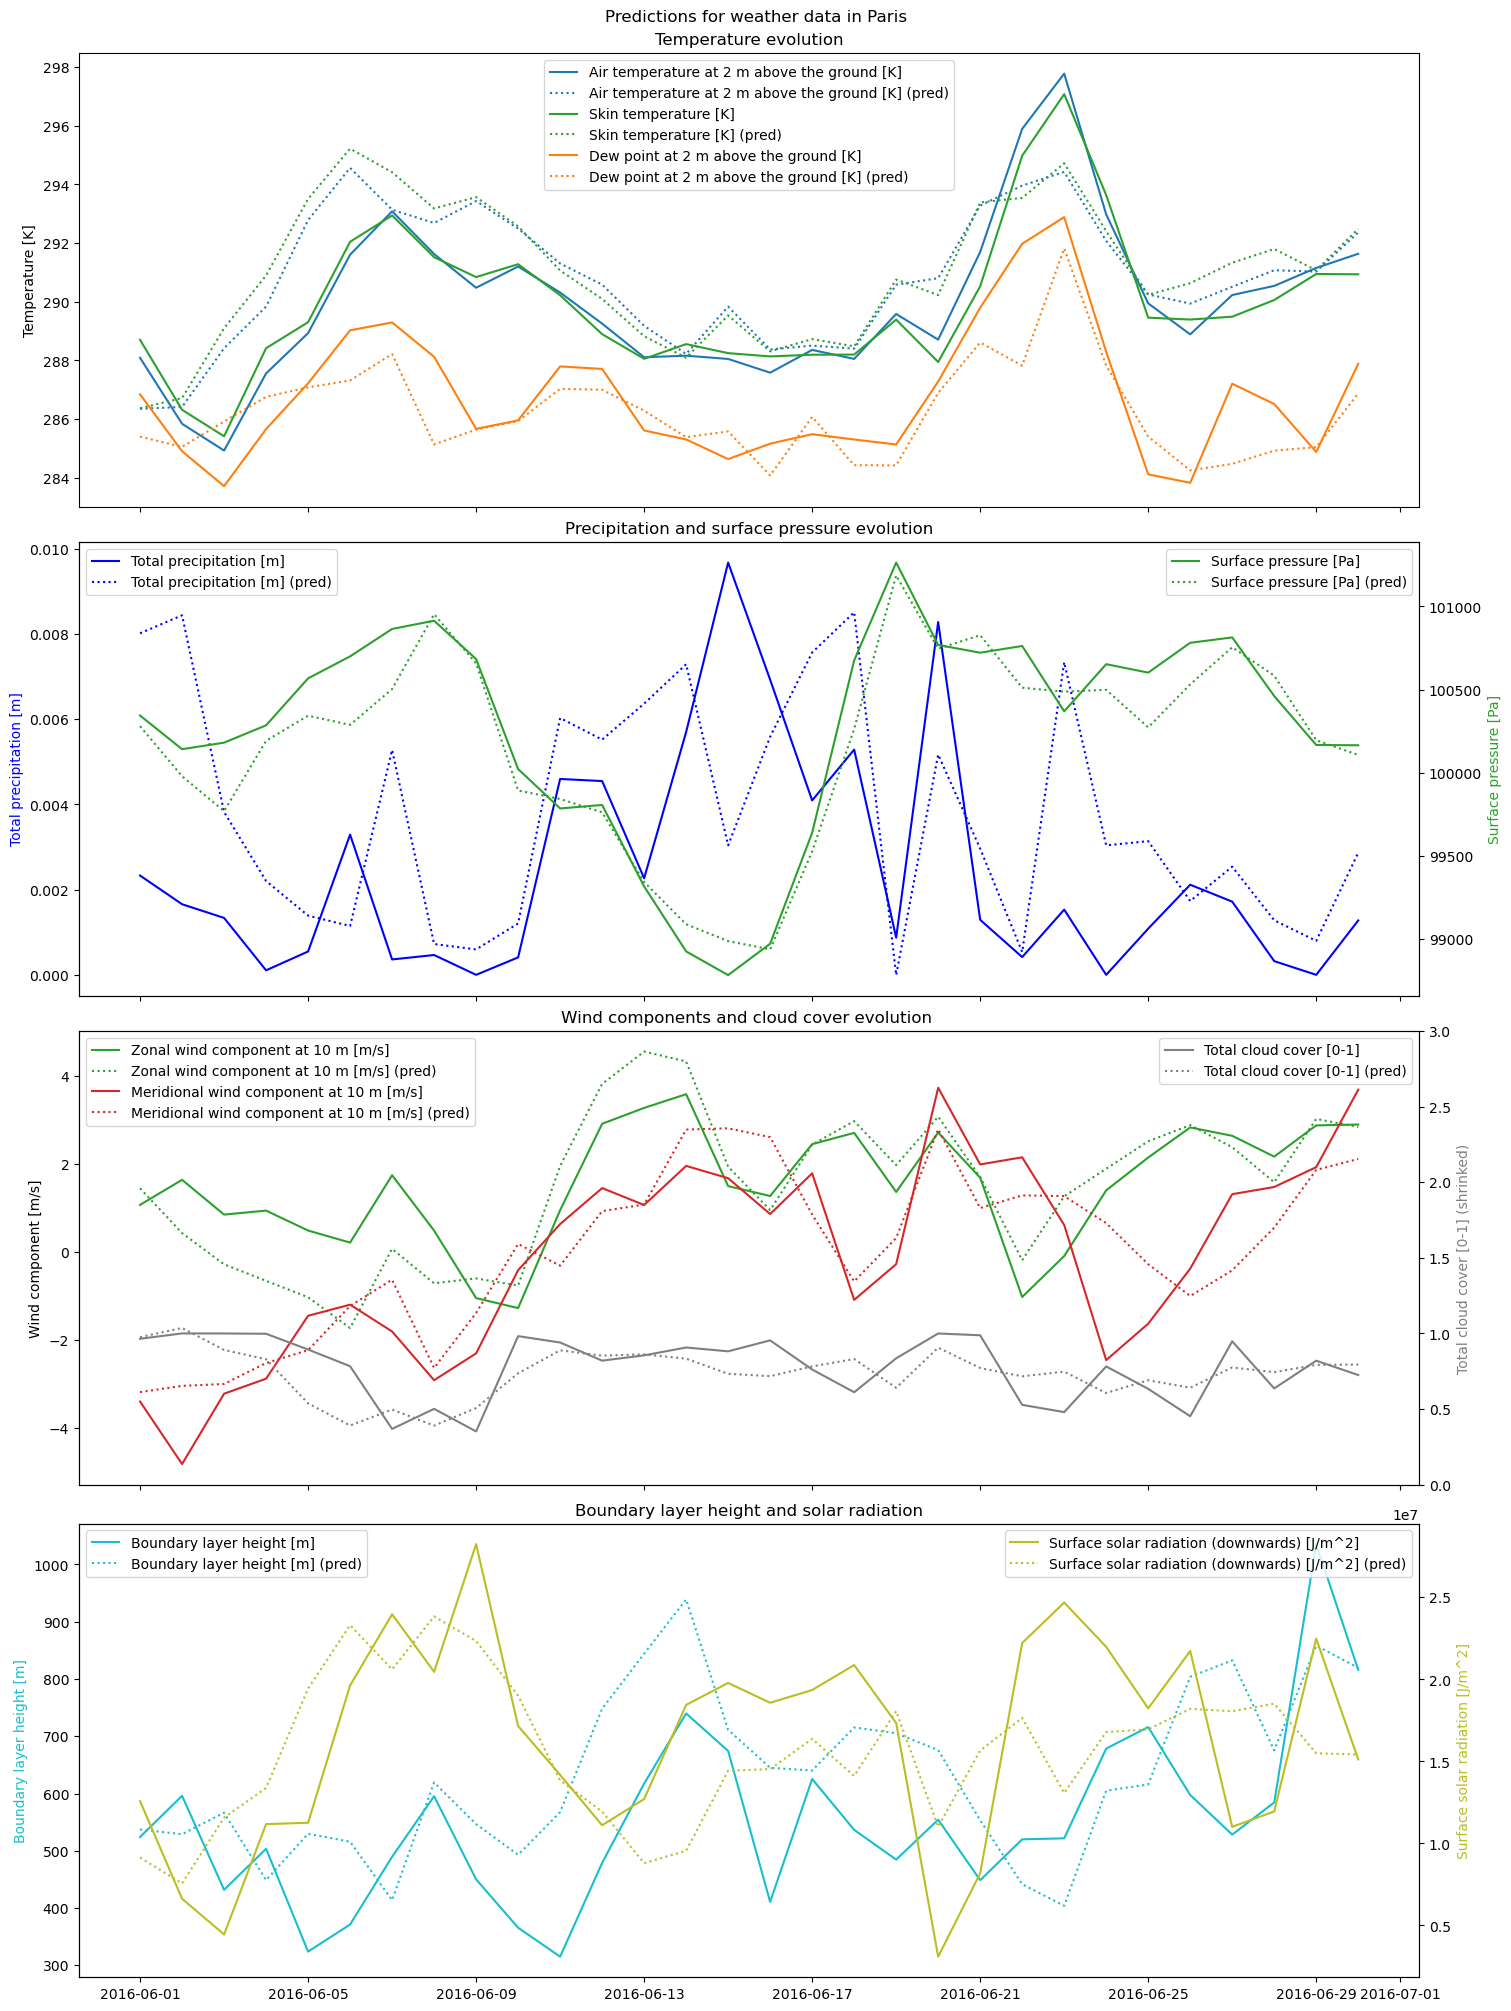

In [45]:
# Display the predictions and the actual values for the first 30 days of the test set = june 2016
display.display_predictions_with_actual(
    y_pred_gru, y_test_rn, scalers, from_date="2016-06-01", to_date="2016-06-30"
)

<div class="alert alert-block alert-info">

The `GRU` model improved our predictions on seven of the features.

**On average, the overall mse has slightly improved.** Mission completed.
</div>

#### 3.4.4 CONV1D

In [46]:
reload(DL_models)
# Model parameters
input_size = X_train_3.shape[1]
output_size = y_train_rn.shape[1]
num_epochs = 100
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
conv1D_model = DL_models.Conv1DModel(input_size, output_size)
model_name = "Conv1D_model"
criterion = nn.MSELoss()
optimizer = optim.Adam(conv1D_model.parameters(), lr=learning_rate)

In [47]:
# Train the model
if RETRAIN_MODELS:
    train_losses, test_losses = DL_models.train_model(
        conv1D_model, train_loader, test_loader, criterion, optimizer, num_epochs, 5
    )
    DL_models.save_model(conv1D_model, model_name)
    # Display the losses
    display.display_losses(train_losses, test_losses, model_name)
else:
    model = DL_models.load_model(conv1D_model, model_name)

Model loaded from models/Conv1D_model.pt


In [48]:
# Evaluate the CONV1D model
y_pred, _ = DL_models.evaluate_model(conv1D_model, test_loader, criterion)
y_pred_conv1D = pd.DataFrame(
    y_pred, index=X_test_rn.index, columns=target_variables_names
)
conv1D_mse, styled_df = display.display_mse_by_year(y_pred_conv1D, y_test_rn)
styled_df

In [49]:
# Compare the CONV1D model with the baseline model
print("Base line vs CONV1D model, reduction of MSE per variable")
_, styled_df = display.display_delta(baseline_global_mse, conv1D_mse)
styled_df


Base line vs CONV1D model, reduction of MSE per variable


In [50]:
print(
    f"Overall mse improved of {baseline_global_mse.loc["all"].mean() - conv1D_mse.loc["all"].mean():.5f} points with {model_name}."
)

Overall mse improved of -0.14923 points with Conv1D_model.


#### 3.4.5 Transformer model

In [51]:
reload(DL_models)
# Model parameters
input_size = X_train_3.shape[1]
embed_dim = 128
num_heads = 8
num_encoder_layers = 4
hidden_dim = 256
output_size = y_train_rn.shape[1]
dropout_rate = 0.3
num_epochs = 60
learning_rate = 0.0001

# Initialize the model, loss function, and optimizer
transformer_model = DL_models.TransformerModel(
    input_size,
    embed_dim,
    num_heads,
    num_encoder_layers,
    hidden_dim,
    output_size,
    dropout_rate,
)
model_name = "Transformer_model"
criterion = nn.MSELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=learning_rate)

In [52]:
# Train the model
RETRAIN_MODELS = False
if RETRAIN_MODELS:
    train_losses, test_losses = DL_models.train_model(
        transformer_model, train_loader, test_loader, criterion, optimizer, 30, 1
    )
    DL_models.save_model(transformer_model, model_name)
    # Display the losses
    display.display_losses(train_losses, test_losses, model_name)
else:
    transformer_model = DL_models.load_model(transformer_model, model_name)

Model loaded from models/Transformer_model.pt


In [53]:
# Evaluate the Transformer model
reload(DL_models)
y_pred, _ = DL_models.evaluate_model(transformer_model, test_loader, criterion)
y_pred_transformer = pd.DataFrame(
    y_pred, index=X_test_rn.index, columns=target_variables_names
)
transformer_mse, styled_df = display.display_mse_by_year(y_pred_transformer, y_test_rn)
styled_df

In [54]:
# Compare the Transformer model with the baseline model
print("Base line vs Transformer model, reduction of MSE per variable")
_, styled_df = display.display_delta(baseline_global_mse, transformer_mse)
styled_df

Base line vs Transformer model, reduction of MSE per variable


In [55]:
print(
    f'Overall mse improved of {baseline_global_mse.loc["all"].mean() - transformer_mse.loc["all"].mean():.5f} points with {model_name}.'
)

Overall mse improved of -0.20385 points with Transformer_model.


<div class="alert alert-block alert-info">

We did not manage to tune the `Transformer` to perform better.
</div>

### 3.5 Model comparison

#### 3.5.1 MSE comparison (lower is better)

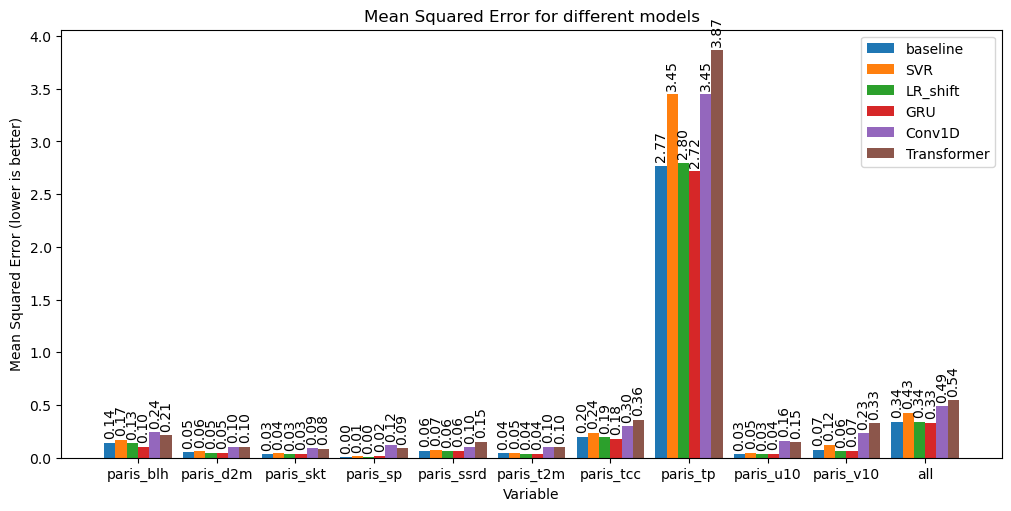

In [56]:
# To update with selected models
selected_models_mse_dict = {
    "baseline": baseline_global_mse,
    "SVR": best_svr_mse,
    "LR_shift": lr_shift_mse,
    "GRU": gru_mse,
    "Conv1D": conv1D_mse,
    "Transformer": transformer_mse,
}
reload(display)
display.compare_models_mse(selected_models_mse_dict)

<div class="alert alert-block alert-info">

For now , the `GRU` model performs the best on nearly all features and have the best overall MSE.
The precipitation is visually hard to predict.
</div>

### 3.5.3 Ensemble creation
**New idea**: Merge the predictions of the best models to create our best predictor. **We selected the average value of our 3 best models.**

In [57]:
# Merge the predictions of the three models
y_pred_merged = (y_pred_baseline_global + y_pred_gru + y_pred_conv1D) / 3
merged_mse, _ = display.display_mse_by_year(y_pred_merged, y_test_rn)
_, styled_df = display.display_delta(baseline_global_mse, merged_mse)
styled_df

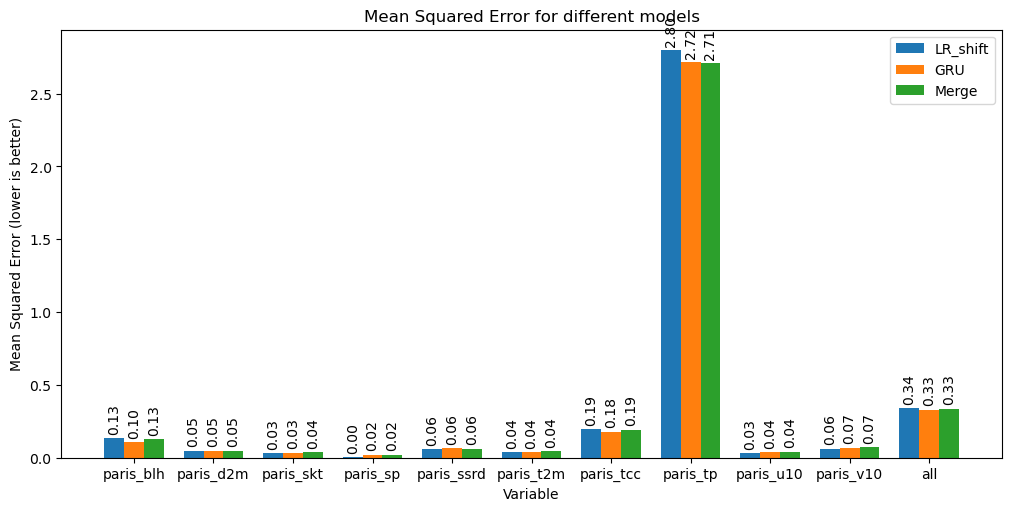

In [58]:
# To update with selected models
selected_models_mse_dict = {
    "LR_shift": lr_shift_mse,
    "GRU": gru_mse,
    "Merge": merged_mse,
}
reload(display)
display.compare_models_mse(selected_models_mse_dict)

<div class="alert alert-block alert-info">

The merge predictor is more accurate on 7 features, including the precipitation. It reaches the same level of accuracy than the GRU, so far our best model.
</div>

---
## 4. Detection of anomalies
<div class="alert alert-block alert-info">

**Aim of this part**:<br>
We suspect that the Paris weather station was cyberhacked in a very subtil way in 2019. We are looking at **incoherences in its reports**.

**Study plan**: <br>
Our best predictor is stated as reliable and will serve has comparison. We will train **two different unsupervised classifiers** to spot out anomalies between the predicted data for the day and the data reported by Paris. The first will be a `Kmeans` and the second an `IsolationForest`. We will switch the datasets as follow:
- "Suspicious" time-frame (test): year 2016-2018. We are expecting 1 day per year of corrupted data during this period. The difference between the prediction and the actual reports on this period is our new training data.
- "Real time" stream (validation): year 2019. We want to analyze  every outlier spotted by our models.


</div>

### 4.1 Dataset preparation

So far our best model was the `GRU`. We will use it to predict the values on the test and validation data.

In [59]:
# Test set  -> new Train set
y_pred, _ = DL_models.evaluate_model(gru_model, test_loader, criterion)
y_pred_gru_test = pd.DataFrame(y_pred, index=X_test_rn.index, columns=y_test_rn.columns)
X_ano_train = y_pred_gru_test - y_test_rn

# Create the validation set that was untouched so far
X_val_3 = load_data.add_shift_previous_days(X_val_rn, 3)
val_loader: DataLoader = DL_models.create_data_loader(
    X=X_val_3, y=y_val_rn, batch_size=batch_size, shuffle=False
)
# Validation set --> new Test set
y_pred, _ = DL_models.evaluate_model(gru_model, val_loader, criterion)
y_pred_gru_val = pd.DataFrame(y_pred, index=X_val_rn.index, columns=y_test_rn.columns)
X_ano_test = y_pred_gru_val - y_val_rn
print(f"X_ano_train shape: {X_ano_train.shape}, X_ano_test shape: {X_ano_test.shape}")


X_ano_train shape: (1096, 10), X_ano_test shape: (365, 10)


### 4.2 Unsupervised classification

#### 4.2.1 Kmeans
The kmeans model does not directly detect outliers. We will fit the best model we can on the train data. Then we will spot out the worst data (the farthest from the cluster center). Finally, we will set a threshold to spot 1 corrupt data per year.

**Model training**

In [60]:
# conduct an extensive Grid Search to find the best parameters for the KMeans model
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

parameter_grid = {
    "n_clusters": np.arange(1, 300, 5),
    "tol": np.logspace(-5, 1, 20),
    "random_state": [0, 1],
}
gs_kmeans = GridSearchCV(KMeans(), param_grid=parameter_grid, n_jobs=-1, refit=True)
gs_kmeans.fit(X_ano_train)


# Display the best parameters
print(f"Best parameters: {gs_kmeans.best_params_}")

/Users/tristanwaddington/anaconda3/envs/ML_climate/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'n_clusters': 296, 'random_state': 0, 'tol': 0.26366508987303555}


Anomaly threshold: 0.6252069102685139
3 anomalies detected on the training set at 2016-03-09, 2016-06-24, 2017-04-24.


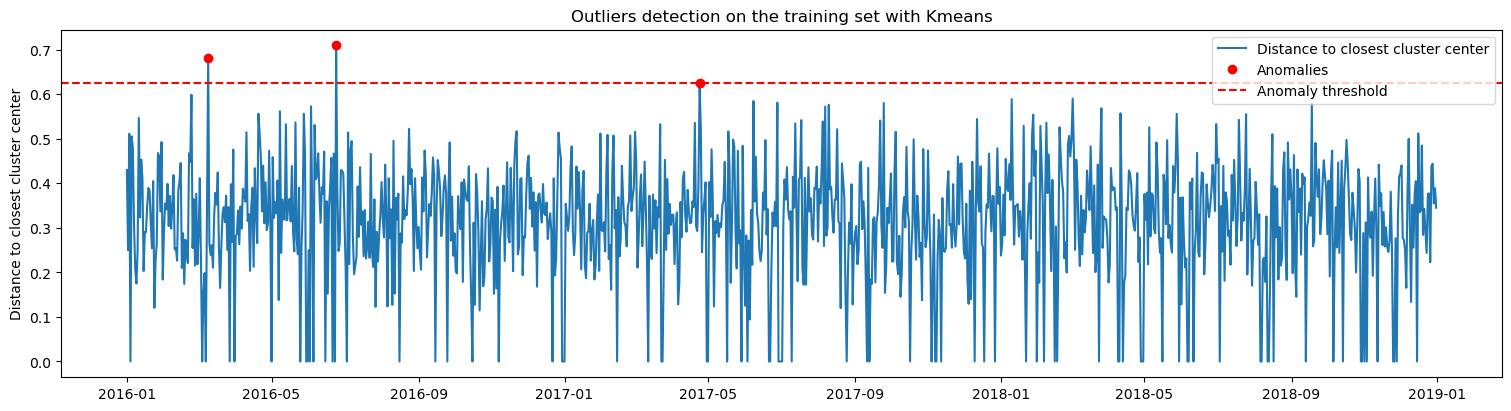

In [61]:
# get the distance of each day from the cluster center
X_ano_train_distance = gs_kmeans.best_estimator_.transform(X_ano_train).min(axis=1)

# Select the anomaly threshold
nb_years = X_ano_train.index.year.nunique()
anomaly_yearly_ratio = 1
anomaly_threshold = X_ano_train_distance[
    np.argsort(X_ano_train_distance)[-nb_years * anomaly_yearly_ratio]
]
print(f"Anomaly threshold: {anomaly_threshold}")

# Display the anomalies on a time line
display.display_anomalies(X_ano_train, X_ano_train_distance, anomaly_threshold)

**Anomaly detection on 2019**: <br>
Now that our model detect anomalies, let's check the 2019 data:

72 anomalies detected on the training set at 2019-01-05, 2019-01-29, 2019-02-02, 2019-03-11, 2019-04-03, 2019-04-05, 2019-04-08, 2019-04-10, 2019-04-16, 2019-04-26, 2019-05-09, 2019-05-11, 2019-05-16, 2019-05-18, 2019-05-21, 2019-06-05, 2019-06-07, 2019-06-09, 2019-06-11, 2019-06-12, 2019-06-13, 2019-06-26, 2019-06-27, 2019-06-28, 2019-06-29, 2019-07-08, 2019-07-09, 2019-07-23, 2019-07-25, 2019-07-26, 2019-07-27, 2019-07-30, 2019-08-06, 2019-08-09, 2019-08-10, 2019-08-26, 2019-08-27, 2019-09-09, 2019-09-12, 2019-09-13, 2019-09-18, 2019-09-19, 2019-09-20, 2019-09-22, 2019-09-30, 2019-10-03, 2019-10-07, 2019-10-08, 2019-10-11, 2019-10-12, 2019-10-13, 2019-10-16, 2019-10-20, 2019-10-21, 2019-10-24, 2019-10-28, 2019-10-29, 2019-10-30, 2019-11-08, 2019-11-11, 2019-11-12, 2019-11-14, 2019-11-16, 2019-11-23, 2019-12-06, 2019-12-12, 2019-12-13, 2019-12-16, 2019-12-19, 2019-12-20, 2019-12-22, 2019-12-31.


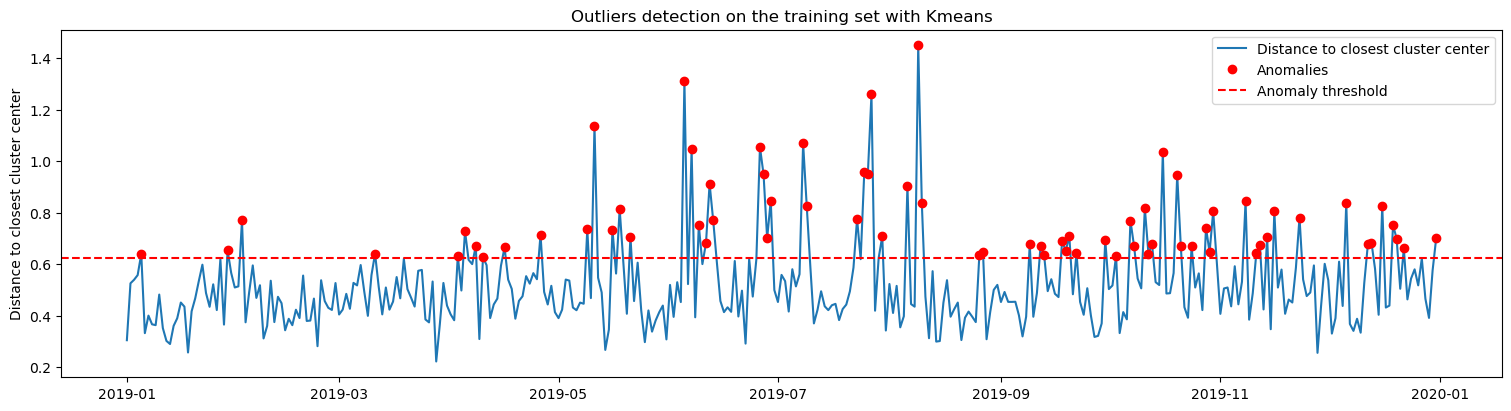

In [62]:
# Run on the validation set
X_ano_test_distance = gs_kmeans.best_estimator_.transform(X_ano_test).min(axis=1)
outliers_idx = np.nonzero(X_ano_test_distance >= anomaly_threshold)[0]

# Display the anomalies on a time line
display.display_anomalies(X_ano_test, X_ano_test_distance, anomaly_threshold)

<div class="alert alert-block alert-info">

The greatest distances with our previous cluster is found in the summer of 2019. 
We will have a look on it on the next part.
</div>


#### 4.2.2 Isolation Forest

The `IsolationForest` detects directly outliers. We just have to specify the contamination rate to match the Kmeans anomaly detection. 

**Model training**

3 anomalies detected on the train set at date 2017-06-30, 2018-04-30, 2018-11-03 


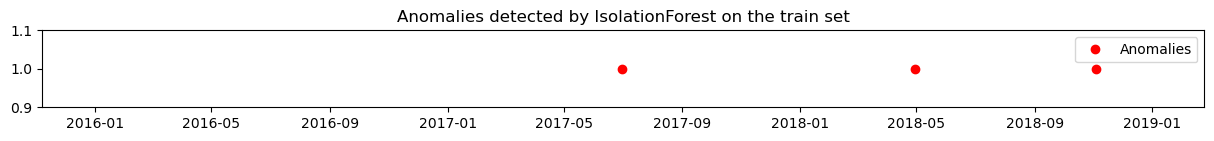

In [63]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(
    n_estimators=100,
    max_samples=0.2,
    contamination=anomaly_yearly_ratio / 365,
    random_state=1,
)
y_ano_train = iforest.fit_predict(X_ano_train)
print(
    f"{np.sum(y_ano_train==-1)} anomalies detected on the train set at date {', '.join(date.strftime('%Y-%m-%d') for date in X_ano_train.index[y_ano_train  ==-1])} "
)

# Display the outliers on a Time line
fig, ax = plt.subplots(figsize=(15, 1))
ax.plot(X_ano_train.index, y_ano_train == -1, "ro", label="Anomalies")
ax.set_ybound(0.9, 1.1)

ax.legend()
ax.set_title("Anomalies detected by IsolationForest on the train set")
plt.show()

**Anomaly detection on 2019**: <br>
Now that our model detect anomalies, let's check the 2019 data:

1 anomalies detected on the train set at date 2019-06-26 


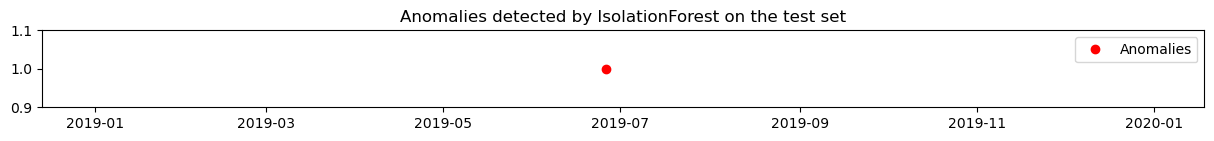

In [64]:
y_ano_test = iforest.fit_predict(X_ano_test)
print(
    f"{np.sum(y_ano_test==-1)} anomalies detected on the train set at date {', '.join(date.strftime('%Y-%m-%d') for date in X_ano_test.index[y_ano_test  ==-1])} "
)

# Display the outliers on a Time line
fig, ax = plt.subplots(figsize=(15, 1))
ax.plot(X_ano_test.index, y_ano_test == -1, "ro", label="Anomalies")
ax.set_ybound(0.9, 1.1)

ax.legend()
ax.set_title("Anomalies detected by IsolationForest on the test set")
plt.show()

<div class="alert alert-block alert-info">

The `Isolation Forest` seems to have stick with the anomaly ration of 1/year. But, the only one detected is also in the summer. Let's try to understand what has triggered the detection.
</div>


### 4.3 Outliers analyze

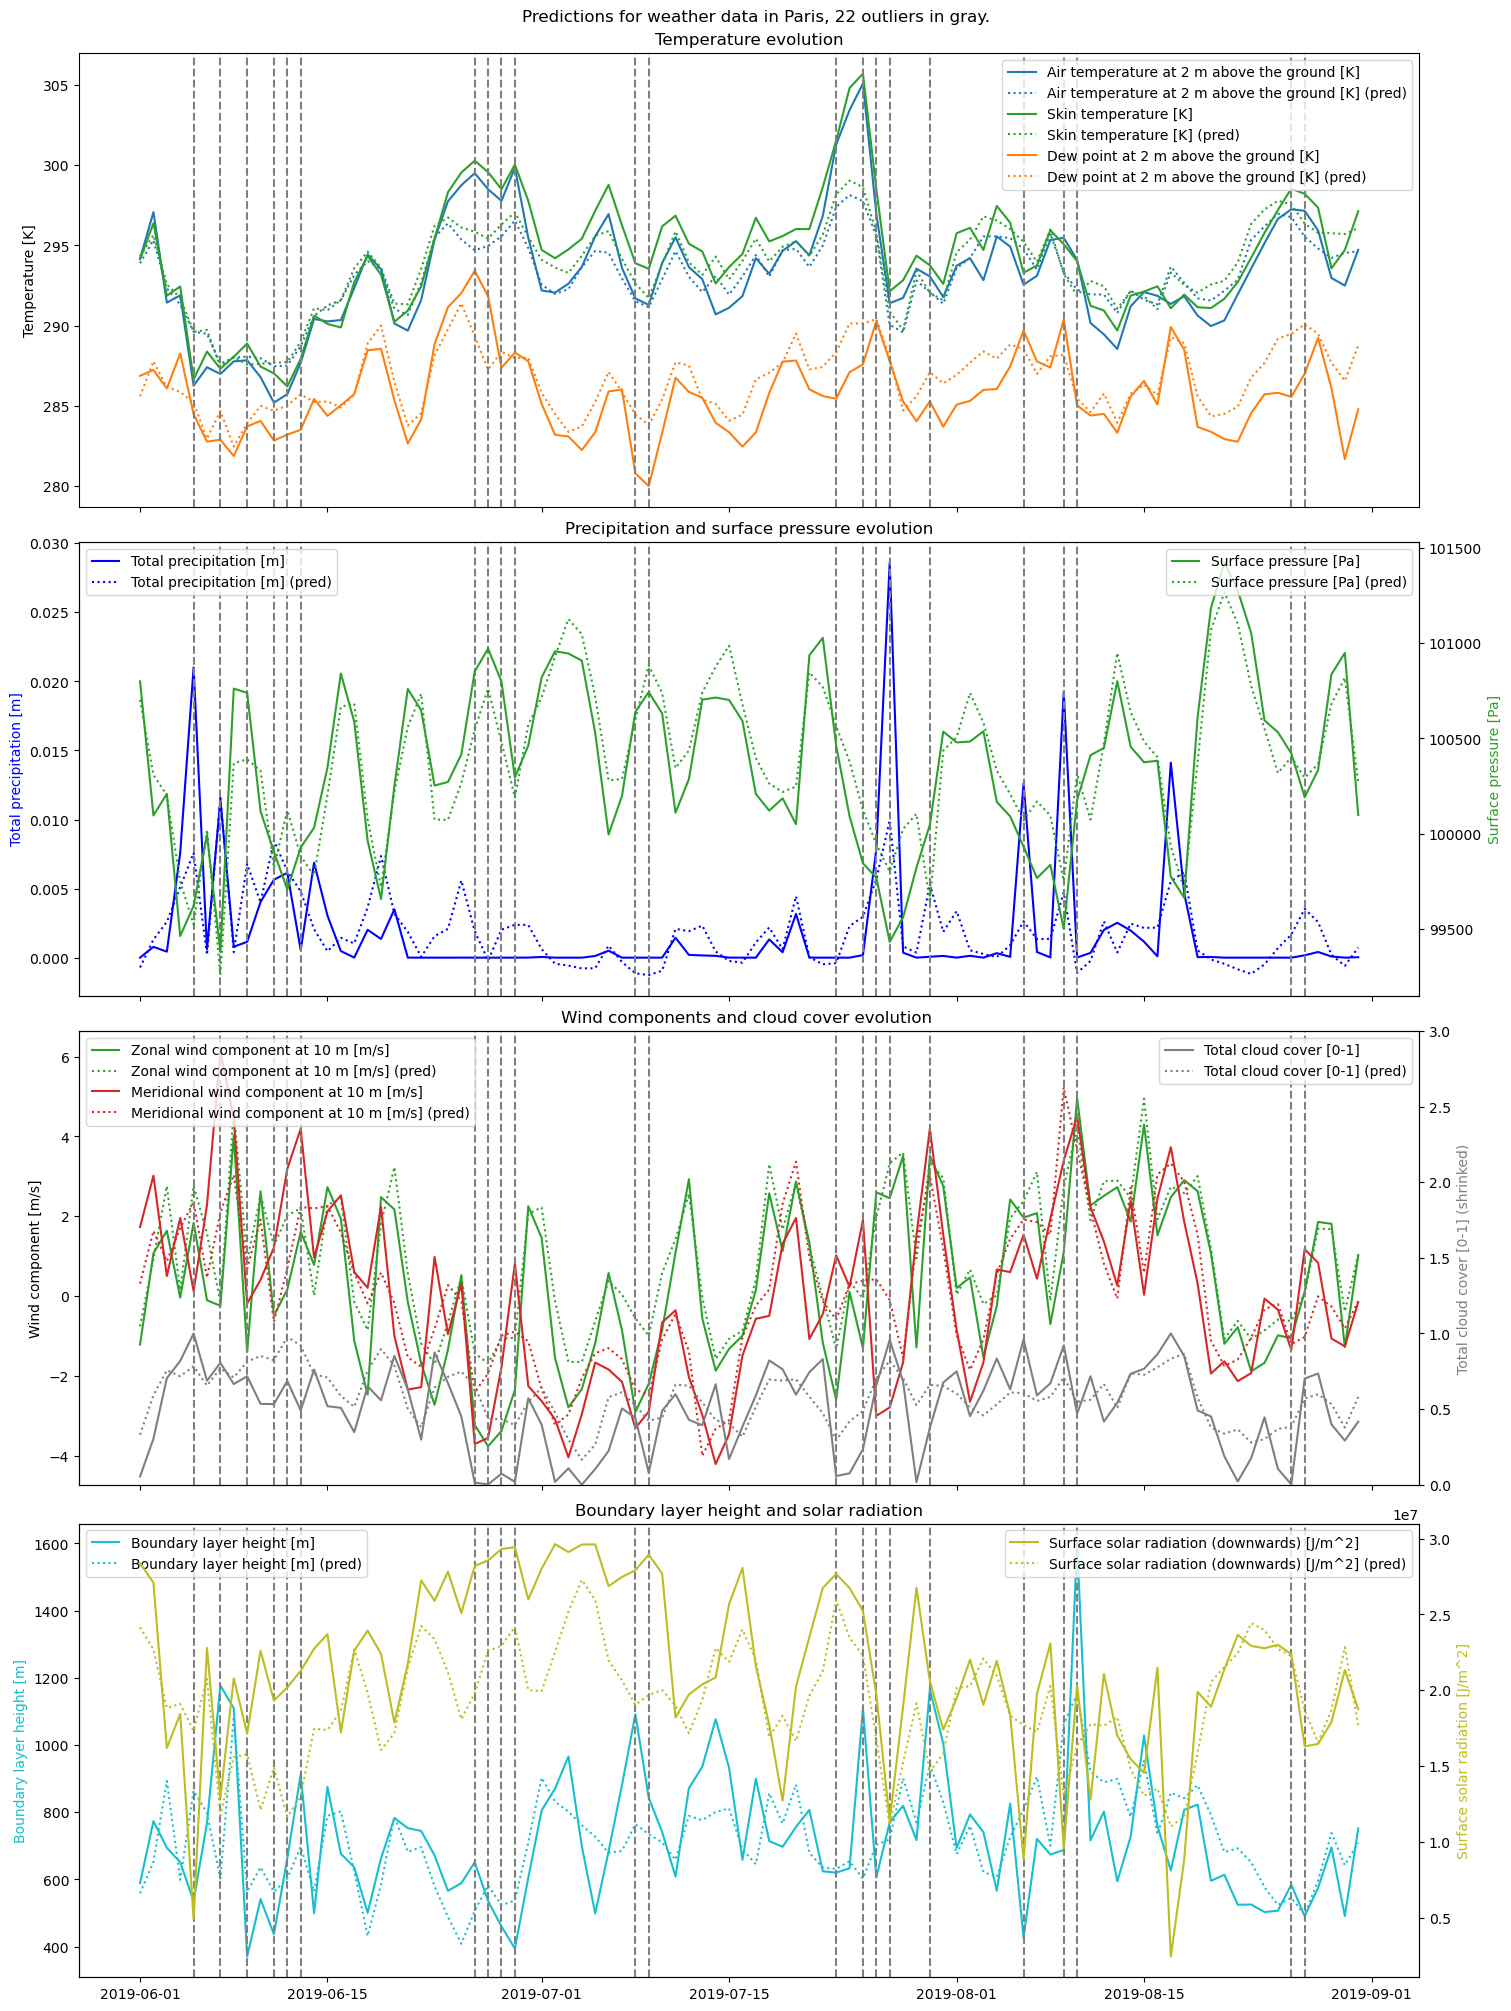

In [65]:
reload(display)
# get the outliers in the summer 2019
outliers_2019 = X_ano_test.index[outliers_idx]
# Display the anomalies on top of the actual and predicted values
display.display_predictions_with_actual(
    y_pred_gru_val,
    y_val_rn,
    scalers,
    from_date="2019-06-01",
    to_date="2019-08-31",
    # var_list=["paris_t2m", "paris_d2m", "paris_ssrd"],
    outliers_idx=outliers_2019,
)

<div class="alert alert-block alert-info">

**k-means outliers analysis**: <br>
The `Kmean` seems to detect extrema in the features. The most explicable ones are the high precipitation or the totally sunny days. Very quick winds also trigger an anomaly.


**Our assumption of cyberhacking may be unfounded. The only anomaly detected refers to uncommon weather phenomenons.**
</div>


## 5. Conclusion

<div class="alert alert-block alert-info">

**About the dataset**:<br>
- We have already worked on an example of the dataset, with the same features. This helps us **start quickly** because we already had examples on how to load and use the data. 
- Furthermore, each variable has a physical representation that our human brain can understand from our daily experience.
- We have used the **resample to daily average** dataset. That means that individual reports are averaged with the ones on the same day. We may have missed some anomalies that could have been dug into.

**About the project and objectives**:<br>
- The project was ambitious because it relies on two successive steps that cannot be done separately: **supervised regression then unsupervised-classification**. We are pretty proud to have managed it. We have use numerous and different models, even if lots did not perform.

**About the team organization**: <br>
- For an easy merge of the different works, we advise that ones focuses on the data preparation and create the first utility functions with an example of expected models. This ensures compatibility and consistency on the final notebook.
- One restraint was to have beautiful plots. The utility file named display.py give pre-computed plots to preserve visual consistency during the notebook for the plots and the DataFrames.

**If we had to do it again** <br>
- keep:
    - Start to work early, there is a lot to do.
    - Work on draft notebooks, then rationalize the final notebook for displaying purposes.
    - Create *.py files to store big part of codes.
    - Save the models weights to ensure reproducibility.
- change:
    - We tried directly to predict the whole dataset. Maybe indiviual and different models could have perform better on different features. The resulting best predictor will then be a merge of the per-features model.
    - The scaling of the data was a real pain to implement, especially when we wanted to rescale back the data to display the results at the end for explainability. Maybe it exists a simpler way. Whatever the inverse-scalers need to be kept in memory.
- **Future exploration** on a next project: 
    - we should retrain the models on the original hourly data to better detect the timeslots of anomalies;
    - we could simulate a datastream, with modified data, and spot if our model detects the incorrect values.

</div>